Image classification with CNNs
================

The goal of this exercise is to implement a specific CNN architecture with PyTorch and train it on the CIFAR-10 image classification dataset. We will start by introducing the dataset and then implement a `nn.Module` and a useful `Solver` class. Seperating the model from the actual training has proven itself as a sensible design decision. By the end of this exercise you should have succesfully trained your (possible) first CNN model and have a boilerplate `Solver` class which you can reuse for the next exercise and your future research projects.

For an inspiration on how to implement a model or the solver class you can have a look at [these](https://github.com/pytorch/examples) PyTorch examples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from dl4cv.classifiers.classification_cnn import ClassificationCNN
from dl4cv.data_utils import get_CIFAR10_datasets, OverfitSampler, rel_error

#torch.set_default_tensor_type('torch.FloatTensor')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

CIFAR-10 Dataset
=========

Since the focus of this exercise should be neural network models and how to successfully train them, we provide you with preprocessed and prepared datasets. For an even easier management of the train, validation and test data pipelines we provide you with custom `torch.utils.data.Dataset` classes. Use the official [documentation](http://pytorch.org/docs/data.html) to make yourself familiar with the `Dataset` and `DataLoader` classes. Think about how you have to integrate them in your training loop and have a look at the data preprocessing steps in `dl4cv/data_utils.py`.

The `num_workers` argument of the `DataLoader` class allows you to preprocess data with multiple threads.

<div class="alert alert-info">
    <h3>Note</h3>
    <p>In this case we generated the `Dataset` classes after we applied all the preprocessing steps. Other datasets or random data augmentation might require an online preprocessing which can be integrated into the `Dataset` classes. See `torchvision.Transform` for examples.</p>
</div>

In [2]:
# Load the (preprocessed) CIFAR10 data. The preprocessing includes
# channel swapping, normalization and train-val-test splitting.
# Loading the datasets might take a while.

train_data, val_data, test_data, mean_image = get_CIFAR10_datasets()
print("Train size: %i" % len(train_data))
print("Val size: %i" % len(val_data))
print("Test size: %i" % len(test_data))

Train size: 48000
Val size: 1000
Test size: 1000


Visualize Examples
------------------

To make yourself familiar with the dataset we visualize some examples. We show a few examples from each class. Note that we have to revert (transposition and mean subtraction) some preprocessing steps.

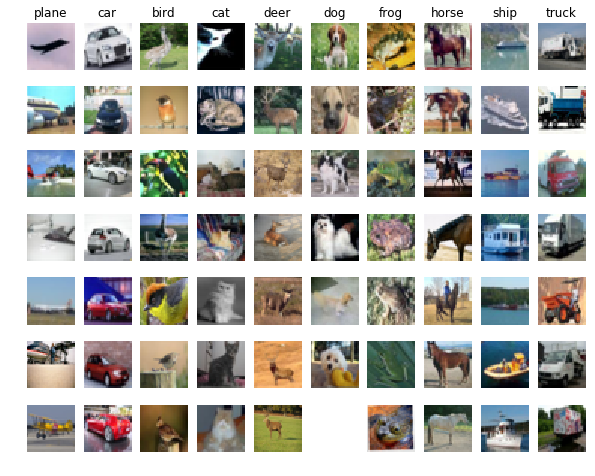

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for cls_idx, cls in enumerate(classes):
    cls_data = [datum for datum in test_data if datum[1] == cls_idx]
    rnd_idxs = np.random.randint(0, len(cls_data), samples_per_class)
    rnd_cls_data = [datum for i, datum in enumerate(cls_data) if i in rnd_idxs]
    for i, cls_datum in enumerate(rnd_cls_data):
        plt_idx = i * num_classes + cls_idx + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(cls_datum[0].numpy().transpose(1,2,0) + mean_image.transpose(1,2,0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Model Architecture and Forward Pass 

After you understood the core concepts of PyTorch and have a rough idea on how to implement your own model, complete the initialization and forward methods of the `ClassificationCNN` in the `dl4cv/classifiers/classification_cnn.py` file. Note that we do not have to implement a backward pass since this is automatically handled by the `autograd` package.

Use the cell below to check your results:

In [4]:
from dl4cv.classifiers.classification_cnn import ClassificationCNN

torch.manual_seed(0)
np.random.seed(0)

X = np.random.randn(2, 3, 5, 5).astype(np.float32)
X_tensor = torch.from_numpy(X.copy())
inputs = Variable(X_tensor)

model = ClassificationCNN(input_dim=(3, 5, 5), num_classes=3)
#print("input size = ", input.size)
outputs = model.forward(inputs)
correct_outputs = np.array([[-0.012747,    0.05964366,  0.03898076],
                            [-0.01286934,  0.05963349,  0.03903975]])

# The difference should be very small. We get < 1e-6
print('Difference between the correct and your forward pass:')
print(outputs.data.numpy())
print(rel_error(correct_outputs, outputs.data.numpy()))

layer 1:  5 5 32
after maxpool:  2 2 32
Difference between the correct and your forward pass:
[[-0.012747    0.05964366  0.03898075]
 [-0.01286935  0.05963349  0.03903975]]
1.95201428952e-07


## Training and Validation with the Solver
We train and validate our previously generated model with a seperate `Solver` class defined in `dl4cv/solver.py`. Complete the `.train()` method and try to come up with an efficient iteration scheme as well as an informative training logger.

Use the cells below to test your solver. A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

<div class="alert alert-info">
    <h3>Note</h3>
    <p>As seen below, the design of our `Solver` class is indepdenent of the particular model or data pipeline. This facilitates the reuse of the class and its modular structure allows the training of different models.</p>
</div>

In [5]:
from dl4cv.classifiers.classification_cnn import ClassificationCNN
from dl4cv.solver import Solver

num_train = 100
train_loader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=False, num_workers=4,
                                           sampler=OverfitSampler(num_train))
val_loader = torch.utils.data.DataLoader(val_data, batch_size=50, shuffle=False, num_workers=4)

overfit_model = ClassificationCNN()
overfit_solver = Solver(optim_args={"lr": 1e-2})
overfit_solver.train(overfit_model, train_loader, val_loader, log_nth=1, num_epochs=20)

layer 1:  32 32 32
after maxpool:  16 16 32
START TRAIN.
[epoch 0 Iteration 0/2] TRAIN loss:  2.310
[epoch 0 Iteration 1/2] TRAIN loss:  4.424
[epoch 0/20] TRAIN acc/loss:  0.130/4.424
[epoch 0/20] VAL acc/loss:  0.111/2.475
[epoch 1 Iteration 0/2] TRAIN loss:  2.569
[epoch 1 Iteration 1/2] TRAIN loss:  2.725
[epoch 1/20] TRAIN acc/loss:  0.100/2.725
[epoch 1/20] VAL acc/loss:  0.100/2.756
[epoch 2 Iteration 0/2] TRAIN loss:  2.903
[epoch 2 Iteration 1/2] TRAIN loss:  2.277
[epoch 2/20] TRAIN acc/loss:  0.150/2.277
[epoch 2/20] VAL acc/loss:  0.140/2.271
[epoch 3 Iteration 0/2] TRAIN loss:  2.228
[epoch 3 Iteration 1/2] TRAIN loss:  2.003
[epoch 3/20] TRAIN acc/loss:  0.310/2.003
[epoch 3/20] VAL acc/loss:  0.168/2.131
[epoch 4 Iteration 0/2] TRAIN loss:  2.008
[epoch 4 Iteration 1/2] TRAIN loss:  1.766
[epoch 4/20] TRAIN acc/loss:  0.350/1.766
[epoch 4/20] VAL acc/loss:  0.191/2.153
[epoch 5 Iteration 0/2] TRAIN loss:  1.808
[epoch 5 Iteration 1/2] TRAIN loss:  1.422
[epoch 5/20] TRAI

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

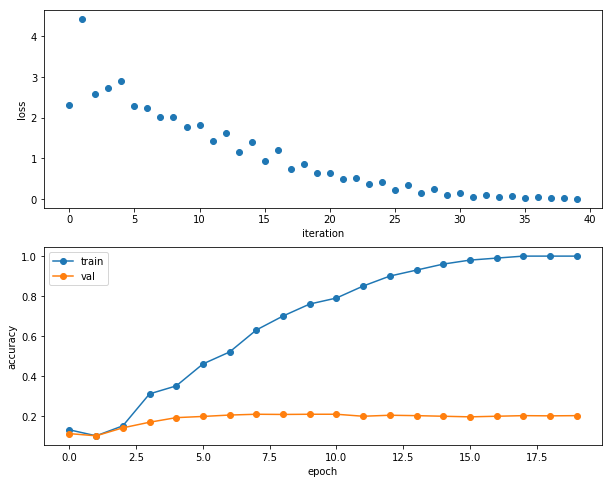

In [6]:
plt.subplot(2, 1, 1)
plt.plot(overfit_solver.train_loss_history, 'o')
plt.plot(overfit_solver.val_loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(overfit_solver.train_acc_history, '-o')
plt.plot(overfit_solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the Network
Now train your model with the full dataset. By training a `ThreeLayerCNN` model for one epoch, you should already achieve greater than 40% accuracy on the validation set. If your training is painfully slow check if you did not forget to call the `nn.Module.cuda()` method.

For the overfitting example we provided you with a set of hyperparamters (`hidden_dim`, `lr`, `weight_decay`, ...). You can start with the same parameter values but in order to maximize your accuracy you should try to train multiple models with different sets of hyperparamters. This process is called hyperparameter optimization.

In [7]:
from dl4cv.classifiers.classification_cnn import ClassificationCNN
from dl4cv.solver import Solver

train_loader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=50, shuffle=False, num_workers=4)

########################################################################
# TODO: Initialize a model and train it using your Solver class. Start #
# with the previously given set of hyperparameters.                    #
########################################################################
model = ClassificationCNN(kernel_size=5, hidden_dim=200)
solver = Solver(optim_args={"lr": 1e-3})
solver.train(model, train_loader, val_loader, log_nth=1, num_epochs=15)

########################################################################
#                             END OF YOUR CODE                         #
#######################################################################

layer 1:  32 32 32
after maxpool:  16 16 32
START TRAIN.
[epoch 0 Iteration 0/960] TRAIN loss:  2.293
[epoch 0 Iteration 1/960] TRAIN loss:  2.317
[epoch 0 Iteration 2/960] TRAIN loss:  2.325
[epoch 0 Iteration 3/960] TRAIN loss:  2.296
[epoch 0 Iteration 4/960] TRAIN loss:  2.298
[epoch 0 Iteration 5/960] TRAIN loss:  2.331
[epoch 0 Iteration 6/960] TRAIN loss:  2.301
[epoch 0 Iteration 7/960] TRAIN loss:  2.309
[epoch 0 Iteration 8/960] TRAIN loss:  2.308
[epoch 0 Iteration 9/960] TRAIN loss:  2.274
[epoch 0 Iteration 10/960] TRAIN loss:  2.303
[epoch 0 Iteration 11/960] TRAIN loss:  2.268
[epoch 0 Iteration 12/960] TRAIN loss:  2.286
[epoch 0 Iteration 13/960] TRAIN loss:  2.285
[epoch 0 Iteration 14/960] TRAIN loss:  2.249
[epoch 0 Iteration 15/960] TRAIN loss:  2.271
[epoch 0 Iteration 16/960] TRAIN loss:  2.163
[epoch 0 Iteration 17/960] TRAIN loss:  2.185
[epoch 0 Iteration 18/960] TRAIN loss:  2.198
[epoch 0 Iteration 19/960] TRAIN loss:  2.189
[epoch 0 Iteration 20/960] TRAIN 

[epoch 0 Iteration 177/960] TRAIN loss:  1.641
[epoch 0 Iteration 178/960] TRAIN loss:  1.781
[epoch 0 Iteration 179/960] TRAIN loss:  1.794
[epoch 0 Iteration 180/960] TRAIN loss:  1.401
[epoch 0 Iteration 181/960] TRAIN loss:  1.847
[epoch 0 Iteration 182/960] TRAIN loss:  1.586
[epoch 0 Iteration 183/960] TRAIN loss:  1.669
[epoch 0 Iteration 184/960] TRAIN loss:  1.674
[epoch 0 Iteration 185/960] TRAIN loss:  1.608
[epoch 0 Iteration 186/960] TRAIN loss:  1.623
[epoch 0 Iteration 187/960] TRAIN loss:  1.828
[epoch 0 Iteration 188/960] TRAIN loss:  1.721
[epoch 0 Iteration 189/960] TRAIN loss:  1.844
[epoch 0 Iteration 190/960] TRAIN loss:  1.809
[epoch 0 Iteration 191/960] TRAIN loss:  1.577
[epoch 0 Iteration 192/960] TRAIN loss:  1.762
[epoch 0 Iteration 193/960] TRAIN loss:  1.926
[epoch 0 Iteration 194/960] TRAIN loss:  1.538
[epoch 0 Iteration 195/960] TRAIN loss:  1.586
[epoch 0 Iteration 196/960] TRAIN loss:  1.739
[epoch 0 Iteration 197/960] TRAIN loss:  1.938
[epoch 0 Iter

[epoch 0 Iteration 354/960] TRAIN loss:  1.617
[epoch 0 Iteration 355/960] TRAIN loss:  1.790
[epoch 0 Iteration 356/960] TRAIN loss:  1.392
[epoch 0 Iteration 357/960] TRAIN loss:  1.478
[epoch 0 Iteration 358/960] TRAIN loss:  1.876
[epoch 0 Iteration 359/960] TRAIN loss:  1.604
[epoch 0 Iteration 360/960] TRAIN loss:  1.708
[epoch 0 Iteration 361/960] TRAIN loss:  1.796
[epoch 0 Iteration 362/960] TRAIN loss:  1.624
[epoch 0 Iteration 363/960] TRAIN loss:  1.671
[epoch 0 Iteration 364/960] TRAIN loss:  1.712
[epoch 0 Iteration 365/960] TRAIN loss:  1.498
[epoch 0 Iteration 366/960] TRAIN loss:  1.573
[epoch 0 Iteration 367/960] TRAIN loss:  1.650
[epoch 0 Iteration 368/960] TRAIN loss:  1.570
[epoch 0 Iteration 369/960] TRAIN loss:  1.621
[epoch 0 Iteration 370/960] TRAIN loss:  1.641
[epoch 0 Iteration 371/960] TRAIN loss:  1.376
[epoch 0 Iteration 372/960] TRAIN loss:  1.656
[epoch 0 Iteration 373/960] TRAIN loss:  1.787
[epoch 0 Iteration 374/960] TRAIN loss:  1.481
[epoch 0 Iter

[epoch 0 Iteration 529/960] TRAIN loss:  1.459
[epoch 0 Iteration 530/960] TRAIN loss:  1.315
[epoch 0 Iteration 531/960] TRAIN loss:  1.475
[epoch 0 Iteration 532/960] TRAIN loss:  1.808
[epoch 0 Iteration 533/960] TRAIN loss:  1.369
[epoch 0 Iteration 534/960] TRAIN loss:  1.268
[epoch 0 Iteration 535/960] TRAIN loss:  1.392
[epoch 0 Iteration 536/960] TRAIN loss:  1.530
[epoch 0 Iteration 537/960] TRAIN loss:  1.694
[epoch 0 Iteration 538/960] TRAIN loss:  1.525
[epoch 0 Iteration 539/960] TRAIN loss:  1.467
[epoch 0 Iteration 540/960] TRAIN loss:  1.398
[epoch 0 Iteration 541/960] TRAIN loss:  1.468
[epoch 0 Iteration 542/960] TRAIN loss:  1.239
[epoch 0 Iteration 543/960] TRAIN loss:  1.517
[epoch 0 Iteration 544/960] TRAIN loss:  1.548
[epoch 0 Iteration 545/960] TRAIN loss:  1.576
[epoch 0 Iteration 546/960] TRAIN loss:  1.877
[epoch 0 Iteration 547/960] TRAIN loss:  1.568
[epoch 0 Iteration 548/960] TRAIN loss:  1.428
[epoch 0 Iteration 549/960] TRAIN loss:  1.662
[epoch 0 Iter

[epoch 0 Iteration 705/960] TRAIN loss:  1.420
[epoch 0 Iteration 706/960] TRAIN loss:  1.524
[epoch 0 Iteration 707/960] TRAIN loss:  1.479
[epoch 0 Iteration 708/960] TRAIN loss:  1.414
[epoch 0 Iteration 709/960] TRAIN loss:  1.852
[epoch 0 Iteration 710/960] TRAIN loss:  1.367
[epoch 0 Iteration 711/960] TRAIN loss:  1.065
[epoch 0 Iteration 712/960] TRAIN loss:  1.590
[epoch 0 Iteration 713/960] TRAIN loss:  1.361
[epoch 0 Iteration 714/960] TRAIN loss:  1.571
[epoch 0 Iteration 715/960] TRAIN loss:  1.536
[epoch 0 Iteration 716/960] TRAIN loss:  1.385
[epoch 0 Iteration 717/960] TRAIN loss:  1.546
[epoch 0 Iteration 718/960] TRAIN loss:  1.288
[epoch 0 Iteration 719/960] TRAIN loss:  1.390
[epoch 0 Iteration 720/960] TRAIN loss:  1.395
[epoch 0 Iteration 721/960] TRAIN loss:  1.387
[epoch 0 Iteration 722/960] TRAIN loss:  1.244
[epoch 0 Iteration 723/960] TRAIN loss:  1.410
[epoch 0 Iteration 724/960] TRAIN loss:  1.396
[epoch 0 Iteration 725/960] TRAIN loss:  1.207
[epoch 0 Iter

[epoch 0 Iteration 881/960] TRAIN loss:  1.387
[epoch 0 Iteration 882/960] TRAIN loss:  1.496
[epoch 0 Iteration 883/960] TRAIN loss:  1.451
[epoch 0 Iteration 884/960] TRAIN loss:  1.517
[epoch 0 Iteration 885/960] TRAIN loss:  1.580
[epoch 0 Iteration 886/960] TRAIN loss:  1.159
[epoch 0 Iteration 887/960] TRAIN loss:  1.507
[epoch 0 Iteration 888/960] TRAIN loss:  1.203
[epoch 0 Iteration 889/960] TRAIN loss:  1.501
[epoch 0 Iteration 890/960] TRAIN loss:  1.412
[epoch 0 Iteration 891/960] TRAIN loss:  1.515
[epoch 0 Iteration 892/960] TRAIN loss:  1.513
[epoch 0 Iteration 893/960] TRAIN loss:  1.365
[epoch 0 Iteration 894/960] TRAIN loss:  1.345
[epoch 0 Iteration 895/960] TRAIN loss:  1.445
[epoch 0 Iteration 896/960] TRAIN loss:  1.277
[epoch 0 Iteration 897/960] TRAIN loss:  1.443
[epoch 0 Iteration 898/960] TRAIN loss:  1.398
[epoch 0 Iteration 899/960] TRAIN loss:  1.303
[epoch 0 Iteration 900/960] TRAIN loss:  1.470
[epoch 0 Iteration 901/960] TRAIN loss:  1.618
[epoch 0 Iter

[epoch 1 Iteration 96/960] TRAIN loss:  0.994
[epoch 1 Iteration 97/960] TRAIN loss:  1.459
[epoch 1 Iteration 98/960] TRAIN loss:  1.232
[epoch 1 Iteration 99/960] TRAIN loss:  1.140
[epoch 1 Iteration 100/960] TRAIN loss:  1.194
[epoch 1 Iteration 101/960] TRAIN loss:  1.066
[epoch 1 Iteration 102/960] TRAIN loss:  1.255
[epoch 1 Iteration 103/960] TRAIN loss:  1.532
[epoch 1 Iteration 104/960] TRAIN loss:  1.429
[epoch 1 Iteration 105/960] TRAIN loss:  1.431
[epoch 1 Iteration 106/960] TRAIN loss:  1.299
[epoch 1 Iteration 107/960] TRAIN loss:  1.258
[epoch 1 Iteration 108/960] TRAIN loss:  1.796
[epoch 1 Iteration 109/960] TRAIN loss:  1.399
[epoch 1 Iteration 110/960] TRAIN loss:  1.452
[epoch 1 Iteration 111/960] TRAIN loss:  1.362
[epoch 1 Iteration 112/960] TRAIN loss:  1.244
[epoch 1 Iteration 113/960] TRAIN loss:  1.308
[epoch 1 Iteration 114/960] TRAIN loss:  1.235
[epoch 1 Iteration 115/960] TRAIN loss:  1.321
[epoch 1 Iteration 116/960] TRAIN loss:  1.364
[epoch 1 Iteratio

[epoch 1 Iteration 272/960] TRAIN loss:  1.295
[epoch 1 Iteration 273/960] TRAIN loss:  1.446
[epoch 1 Iteration 274/960] TRAIN loss:  1.278
[epoch 1 Iteration 275/960] TRAIN loss:  1.370
[epoch 1 Iteration 276/960] TRAIN loss:  1.402
[epoch 1 Iteration 277/960] TRAIN loss:  1.325
[epoch 1 Iteration 278/960] TRAIN loss:  1.486
[epoch 1 Iteration 279/960] TRAIN loss:  1.228
[epoch 1 Iteration 280/960] TRAIN loss:  1.229
[epoch 1 Iteration 281/960] TRAIN loss:  1.409
[epoch 1 Iteration 282/960] TRAIN loss:  1.336
[epoch 1 Iteration 283/960] TRAIN loss:  1.478
[epoch 1 Iteration 284/960] TRAIN loss:  1.268
[epoch 1 Iteration 285/960] TRAIN loss:  1.305
[epoch 1 Iteration 286/960] TRAIN loss:  1.418
[epoch 1 Iteration 287/960] TRAIN loss:  1.500
[epoch 1 Iteration 288/960] TRAIN loss:  1.073
[epoch 1 Iteration 289/960] TRAIN loss:  1.212
[epoch 1 Iteration 290/960] TRAIN loss:  1.561
[epoch 1 Iteration 291/960] TRAIN loss:  1.186
[epoch 1 Iteration 292/960] TRAIN loss:  1.252
[epoch 1 Iter

[epoch 1 Iteration 448/960] TRAIN loss:  1.099
[epoch 1 Iteration 449/960] TRAIN loss:  1.303
[epoch 1 Iteration 450/960] TRAIN loss:  1.253
[epoch 1 Iteration 451/960] TRAIN loss:  1.409
[epoch 1 Iteration 452/960] TRAIN loss:  1.501
[epoch 1 Iteration 453/960] TRAIN loss:  1.384
[epoch 1 Iteration 454/960] TRAIN loss:  1.289
[epoch 1 Iteration 455/960] TRAIN loss:  1.237
[epoch 1 Iteration 456/960] TRAIN loss:  1.190
[epoch 1 Iteration 457/960] TRAIN loss:  1.130
[epoch 1 Iteration 458/960] TRAIN loss:  1.180
[epoch 1 Iteration 459/960] TRAIN loss:  0.993
[epoch 1 Iteration 460/960] TRAIN loss:  1.214
[epoch 1 Iteration 461/960] TRAIN loss:  1.074
[epoch 1 Iteration 462/960] TRAIN loss:  1.100
[epoch 1 Iteration 463/960] TRAIN loss:  1.325
[epoch 1 Iteration 464/960] TRAIN loss:  1.362
[epoch 1 Iteration 465/960] TRAIN loss:  1.095
[epoch 1 Iteration 466/960] TRAIN loss:  1.204
[epoch 1 Iteration 467/960] TRAIN loss:  1.317
[epoch 1 Iteration 468/960] TRAIN loss:  1.373
[epoch 1 Iter

[epoch 1 Iteration 624/960] TRAIN loss:  1.253
[epoch 1 Iteration 625/960] TRAIN loss:  1.096
[epoch 1 Iteration 626/960] TRAIN loss:  1.210
[epoch 1 Iteration 627/960] TRAIN loss:  1.183
[epoch 1 Iteration 628/960] TRAIN loss:  1.377
[epoch 1 Iteration 629/960] TRAIN loss:  1.212
[epoch 1 Iteration 630/960] TRAIN loss:  1.192
[epoch 1 Iteration 631/960] TRAIN loss:  1.540
[epoch 1 Iteration 632/960] TRAIN loss:  1.251
[epoch 1 Iteration 633/960] TRAIN loss:  1.041
[epoch 1 Iteration 634/960] TRAIN loss:  1.200
[epoch 1 Iteration 635/960] TRAIN loss:  0.895
[epoch 1 Iteration 636/960] TRAIN loss:  1.055
[epoch 1 Iteration 637/960] TRAIN loss:  1.106
[epoch 1 Iteration 638/960] TRAIN loss:  1.166
[epoch 1 Iteration 639/960] TRAIN loss:  1.090
[epoch 1 Iteration 640/960] TRAIN loss:  1.071
[epoch 1 Iteration 641/960] TRAIN loss:  1.514
[epoch 1 Iteration 642/960] TRAIN loss:  1.593
[epoch 1 Iteration 643/960] TRAIN loss:  1.100
[epoch 1 Iteration 644/960] TRAIN loss:  1.164
[epoch 1 Iter

[epoch 1 Iteration 800/960] TRAIN loss:  1.209
[epoch 1 Iteration 801/960] TRAIN loss:  1.325
[epoch 1 Iteration 802/960] TRAIN loss:  1.332
[epoch 1 Iteration 803/960] TRAIN loss:  0.987
[epoch 1 Iteration 804/960] TRAIN loss:  1.517
[epoch 1 Iteration 805/960] TRAIN loss:  1.534
[epoch 1 Iteration 806/960] TRAIN loss:  1.149
[epoch 1 Iteration 807/960] TRAIN loss:  1.267
[epoch 1 Iteration 808/960] TRAIN loss:  1.547
[epoch 1 Iteration 809/960] TRAIN loss:  1.077
[epoch 1 Iteration 810/960] TRAIN loss:  1.106
[epoch 1 Iteration 811/960] TRAIN loss:  1.155
[epoch 1 Iteration 812/960] TRAIN loss:  1.204
[epoch 1 Iteration 813/960] TRAIN loss:  1.141
[epoch 1 Iteration 814/960] TRAIN loss:  1.330
[epoch 1 Iteration 815/960] TRAIN loss:  1.258
[epoch 1 Iteration 816/960] TRAIN loss:  1.058
[epoch 1 Iteration 817/960] TRAIN loss:  1.355
[epoch 1 Iteration 818/960] TRAIN loss:  0.869
[epoch 1 Iteration 819/960] TRAIN loss:  1.128
[epoch 1 Iteration 820/960] TRAIN loss:  1.016
[epoch 1 Iter

[epoch 2 Iteration 14/960] TRAIN loss:  1.086
[epoch 2 Iteration 15/960] TRAIN loss:  1.113
[epoch 2 Iteration 16/960] TRAIN loss:  1.122
[epoch 2 Iteration 17/960] TRAIN loss:  1.277
[epoch 2 Iteration 18/960] TRAIN loss:  1.492
[epoch 2 Iteration 19/960] TRAIN loss:  1.266
[epoch 2 Iteration 20/960] TRAIN loss:  1.334
[epoch 2 Iteration 21/960] TRAIN loss:  1.428
[epoch 2 Iteration 22/960] TRAIN loss:  1.198
[epoch 2 Iteration 23/960] TRAIN loss:  1.020
[epoch 2 Iteration 24/960] TRAIN loss:  1.115
[epoch 2 Iteration 25/960] TRAIN loss:  0.903
[epoch 2 Iteration 26/960] TRAIN loss:  1.189
[epoch 2 Iteration 27/960] TRAIN loss:  1.044
[epoch 2 Iteration 28/960] TRAIN loss:  1.342
[epoch 2 Iteration 29/960] TRAIN loss:  1.192
[epoch 2 Iteration 30/960] TRAIN loss:  1.190
[epoch 2 Iteration 31/960] TRAIN loss:  1.089
[epoch 2 Iteration 32/960] TRAIN loss:  1.216
[epoch 2 Iteration 33/960] TRAIN loss:  1.099
[epoch 2 Iteration 34/960] TRAIN loss:  1.135
[epoch 2 Iteration 35/960] TRAIN l

[epoch 2 Iteration 191/960] TRAIN loss:  1.064
[epoch 2 Iteration 192/960] TRAIN loss:  1.039
[epoch 2 Iteration 193/960] TRAIN loss:  1.251
[epoch 2 Iteration 194/960] TRAIN loss:  1.342
[epoch 2 Iteration 195/960] TRAIN loss:  0.961
[epoch 2 Iteration 196/960] TRAIN loss:  1.086
[epoch 2 Iteration 197/960] TRAIN loss:  1.240
[epoch 2 Iteration 198/960] TRAIN loss:  1.418
[epoch 2 Iteration 199/960] TRAIN loss:  0.906
[epoch 2 Iteration 200/960] TRAIN loss:  1.260
[epoch 2 Iteration 201/960] TRAIN loss:  1.108
[epoch 2 Iteration 202/960] TRAIN loss:  1.157
[epoch 2 Iteration 203/960] TRAIN loss:  1.265
[epoch 2 Iteration 204/960] TRAIN loss:  1.319
[epoch 2 Iteration 205/960] TRAIN loss:  1.170
[epoch 2 Iteration 206/960] TRAIN loss:  1.050
[epoch 2 Iteration 207/960] TRAIN loss:  1.189
[epoch 2 Iteration 208/960] TRAIN loss:  1.394
[epoch 2 Iteration 209/960] TRAIN loss:  1.280
[epoch 2 Iteration 210/960] TRAIN loss:  1.501
[epoch 2 Iteration 211/960] TRAIN loss:  1.314
[epoch 2 Iter

[epoch 2 Iteration 367/960] TRAIN loss:  1.394
[epoch 2 Iteration 368/960] TRAIN loss:  1.251
[epoch 2 Iteration 369/960] TRAIN loss:  0.913
[epoch 2 Iteration 370/960] TRAIN loss:  1.069
[epoch 2 Iteration 371/960] TRAIN loss:  1.338
[epoch 2 Iteration 372/960] TRAIN loss:  0.898
[epoch 2 Iteration 373/960] TRAIN loss:  1.186
[epoch 2 Iteration 374/960] TRAIN loss:  1.281
[epoch 2 Iteration 375/960] TRAIN loss:  1.007
[epoch 2 Iteration 376/960] TRAIN loss:  1.124
[epoch 2 Iteration 377/960] TRAIN loss:  0.980
[epoch 2 Iteration 378/960] TRAIN loss:  0.977
[epoch 2 Iteration 379/960] TRAIN loss:  1.625
[epoch 2 Iteration 380/960] TRAIN loss:  1.038
[epoch 2 Iteration 381/960] TRAIN loss:  1.189
[epoch 2 Iteration 382/960] TRAIN loss:  1.116
[epoch 2 Iteration 383/960] TRAIN loss:  1.091
[epoch 2 Iteration 384/960] TRAIN loss:  1.141
[epoch 2 Iteration 385/960] TRAIN loss:  1.209
[epoch 2 Iteration 386/960] TRAIN loss:  1.364
[epoch 2 Iteration 387/960] TRAIN loss:  1.217
[epoch 2 Iter

[epoch 2 Iteration 543/960] TRAIN loss:  1.018
[epoch 2 Iteration 544/960] TRAIN loss:  1.344
[epoch 2 Iteration 545/960] TRAIN loss:  1.057
[epoch 2 Iteration 546/960] TRAIN loss:  1.377
[epoch 2 Iteration 547/960] TRAIN loss:  1.448
[epoch 2 Iteration 548/960] TRAIN loss:  1.520
[epoch 2 Iteration 549/960] TRAIN loss:  1.345
[epoch 2 Iteration 550/960] TRAIN loss:  0.893
[epoch 2 Iteration 551/960] TRAIN loss:  1.419
[epoch 2 Iteration 552/960] TRAIN loss:  1.427
[epoch 2 Iteration 553/960] TRAIN loss:  1.080
[epoch 2 Iteration 554/960] TRAIN loss:  1.041
[epoch 2 Iteration 555/960] TRAIN loss:  0.921
[epoch 2 Iteration 556/960] TRAIN loss:  1.318
[epoch 2 Iteration 557/960] TRAIN loss:  1.024
[epoch 2 Iteration 558/960] TRAIN loss:  1.097
[epoch 2 Iteration 559/960] TRAIN loss:  1.036
[epoch 2 Iteration 560/960] TRAIN loss:  0.885
[epoch 2 Iteration 561/960] TRAIN loss:  0.949
[epoch 2 Iteration 562/960] TRAIN loss:  1.159
[epoch 2 Iteration 563/960] TRAIN loss:  1.174
[epoch 2 Iter

[epoch 2 Iteration 719/960] TRAIN loss:  1.153
[epoch 2 Iteration 720/960] TRAIN loss:  1.004
[epoch 2 Iteration 721/960] TRAIN loss:  1.213
[epoch 2 Iteration 722/960] TRAIN loss:  1.217
[epoch 2 Iteration 723/960] TRAIN loss:  1.319
[epoch 2 Iteration 724/960] TRAIN loss:  1.043
[epoch 2 Iteration 725/960] TRAIN loss:  1.184
[epoch 2 Iteration 726/960] TRAIN loss:  1.090
[epoch 2 Iteration 727/960] TRAIN loss:  1.195
[epoch 2 Iteration 728/960] TRAIN loss:  1.304
[epoch 2 Iteration 729/960] TRAIN loss:  1.158
[epoch 2 Iteration 730/960] TRAIN loss:  0.905
[epoch 2 Iteration 731/960] TRAIN loss:  1.203
[epoch 2 Iteration 732/960] TRAIN loss:  1.234
[epoch 2 Iteration 733/960] TRAIN loss:  0.914
[epoch 2 Iteration 734/960] TRAIN loss:  1.067
[epoch 2 Iteration 735/960] TRAIN loss:  1.393
[epoch 2 Iteration 736/960] TRAIN loss:  1.439
[epoch 2 Iteration 737/960] TRAIN loss:  1.112
[epoch 2 Iteration 738/960] TRAIN loss:  1.045
[epoch 2 Iteration 739/960] TRAIN loss:  1.247
[epoch 2 Iter

[epoch 2 Iteration 894/960] TRAIN loss:  0.935
[epoch 2 Iteration 895/960] TRAIN loss:  0.838
[epoch 2 Iteration 896/960] TRAIN loss:  1.297
[epoch 2 Iteration 897/960] TRAIN loss:  0.828
[epoch 2 Iteration 898/960] TRAIN loss:  1.374
[epoch 2 Iteration 899/960] TRAIN loss:  1.100
[epoch 2 Iteration 900/960] TRAIN loss:  1.358
[epoch 2 Iteration 901/960] TRAIN loss:  0.909
[epoch 2 Iteration 902/960] TRAIN loss:  1.289
[epoch 2 Iteration 903/960] TRAIN loss:  1.001
[epoch 2 Iteration 904/960] TRAIN loss:  1.124
[epoch 2 Iteration 905/960] TRAIN loss:  1.139
[epoch 2 Iteration 906/960] TRAIN loss:  1.283
[epoch 2 Iteration 907/960] TRAIN loss:  0.883
[epoch 2 Iteration 908/960] TRAIN loss:  0.966
[epoch 2 Iteration 909/960] TRAIN loss:  1.098
[epoch 2 Iteration 910/960] TRAIN loss:  1.024
[epoch 2 Iteration 911/960] TRAIN loss:  0.956
[epoch 2 Iteration 912/960] TRAIN loss:  1.068
[epoch 2 Iteration 913/960] TRAIN loss:  1.173
[epoch 2 Iteration 914/960] TRAIN loss:  1.084
[epoch 2 Iter

[epoch 3 Iteration 109/960] TRAIN loss:  0.937
[epoch 3 Iteration 110/960] TRAIN loss:  1.014
[epoch 3 Iteration 111/960] TRAIN loss:  0.952
[epoch 3 Iteration 112/960] TRAIN loss:  0.793
[epoch 3 Iteration 113/960] TRAIN loss:  1.095
[epoch 3 Iteration 114/960] TRAIN loss:  1.094
[epoch 3 Iteration 115/960] TRAIN loss:  1.123
[epoch 3 Iteration 116/960] TRAIN loss:  1.202
[epoch 3 Iteration 117/960] TRAIN loss:  1.097
[epoch 3 Iteration 118/960] TRAIN loss:  1.467
[epoch 3 Iteration 119/960] TRAIN loss:  1.170
[epoch 3 Iteration 120/960] TRAIN loss:  1.157
[epoch 3 Iteration 121/960] TRAIN loss:  1.160
[epoch 3 Iteration 122/960] TRAIN loss:  0.888
[epoch 3 Iteration 123/960] TRAIN loss:  1.027
[epoch 3 Iteration 124/960] TRAIN loss:  1.036
[epoch 3 Iteration 125/960] TRAIN loss:  1.072
[epoch 3 Iteration 126/960] TRAIN loss:  1.061
[epoch 3 Iteration 127/960] TRAIN loss:  1.140
[epoch 3 Iteration 128/960] TRAIN loss:  1.054
[epoch 3 Iteration 129/960] TRAIN loss:  0.837
[epoch 3 Iter

[epoch 3 Iteration 284/960] TRAIN loss:  0.843
[epoch 3 Iteration 285/960] TRAIN loss:  1.216
[epoch 3 Iteration 286/960] TRAIN loss:  0.951
[epoch 3 Iteration 287/960] TRAIN loss:  1.328
[epoch 3 Iteration 288/960] TRAIN loss:  1.142
[epoch 3 Iteration 289/960] TRAIN loss:  1.203
[epoch 3 Iteration 290/960] TRAIN loss:  1.027
[epoch 3 Iteration 291/960] TRAIN loss:  1.134
[epoch 3 Iteration 292/960] TRAIN loss:  0.851
[epoch 3 Iteration 293/960] TRAIN loss:  0.864
[epoch 3 Iteration 294/960] TRAIN loss:  1.153
[epoch 3 Iteration 295/960] TRAIN loss:  1.190
[epoch 3 Iteration 296/960] TRAIN loss:  1.002
[epoch 3 Iteration 297/960] TRAIN loss:  0.957
[epoch 3 Iteration 298/960] TRAIN loss:  1.431
[epoch 3 Iteration 299/960] TRAIN loss:  1.252
[epoch 3 Iteration 300/960] TRAIN loss:  1.109
[epoch 3 Iteration 301/960] TRAIN loss:  1.037
[epoch 3 Iteration 302/960] TRAIN loss:  0.821
[epoch 3 Iteration 303/960] TRAIN loss:  1.179
[epoch 3 Iteration 304/960] TRAIN loss:  0.899
[epoch 3 Iter

[epoch 3 Iteration 460/960] TRAIN loss:  0.882
[epoch 3 Iteration 461/960] TRAIN loss:  0.923
[epoch 3 Iteration 462/960] TRAIN loss:  0.998
[epoch 3 Iteration 463/960] TRAIN loss:  1.014
[epoch 3 Iteration 464/960] TRAIN loss:  1.090
[epoch 3 Iteration 465/960] TRAIN loss:  1.033
[epoch 3 Iteration 466/960] TRAIN loss:  1.143
[epoch 3 Iteration 467/960] TRAIN loss:  1.035
[epoch 3 Iteration 468/960] TRAIN loss:  0.866
[epoch 3 Iteration 469/960] TRAIN loss:  1.035
[epoch 3 Iteration 470/960] TRAIN loss:  0.966
[epoch 3 Iteration 471/960] TRAIN loss:  1.076
[epoch 3 Iteration 472/960] TRAIN loss:  1.158
[epoch 3 Iteration 473/960] TRAIN loss:  1.091
[epoch 3 Iteration 474/960] TRAIN loss:  1.112
[epoch 3 Iteration 475/960] TRAIN loss:  1.275
[epoch 3 Iteration 476/960] TRAIN loss:  0.876
[epoch 3 Iteration 477/960] TRAIN loss:  1.144
[epoch 3 Iteration 478/960] TRAIN loss:  1.164
[epoch 3 Iteration 479/960] TRAIN loss:  1.070
[epoch 3 Iteration 480/960] TRAIN loss:  0.857
[epoch 3 Iter

[epoch 3 Iteration 636/960] TRAIN loss:  1.019
[epoch 3 Iteration 637/960] TRAIN loss:  0.892
[epoch 3 Iteration 638/960] TRAIN loss:  1.045
[epoch 3 Iteration 639/960] TRAIN loss:  1.024
[epoch 3 Iteration 640/960] TRAIN loss:  0.935
[epoch 3 Iteration 641/960] TRAIN loss:  1.239
[epoch 3 Iteration 642/960] TRAIN loss:  1.026
[epoch 3 Iteration 643/960] TRAIN loss:  1.075
[epoch 3 Iteration 644/960] TRAIN loss:  1.529
[epoch 3 Iteration 645/960] TRAIN loss:  1.222
[epoch 3 Iteration 646/960] TRAIN loss:  1.149
[epoch 3 Iteration 647/960] TRAIN loss:  1.328
[epoch 3 Iteration 648/960] TRAIN loss:  1.209
[epoch 3 Iteration 649/960] TRAIN loss:  1.152
[epoch 3 Iteration 650/960] TRAIN loss:  1.064
[epoch 3 Iteration 651/960] TRAIN loss:  0.887
[epoch 3 Iteration 652/960] TRAIN loss:  1.308
[epoch 3 Iteration 653/960] TRAIN loss:  1.263
[epoch 3 Iteration 654/960] TRAIN loss:  0.997
[epoch 3 Iteration 655/960] TRAIN loss:  1.209
[epoch 3 Iteration 656/960] TRAIN loss:  1.154
[epoch 3 Iter

[epoch 3 Iteration 813/960] TRAIN loss:  1.036
[epoch 3 Iteration 814/960] TRAIN loss:  1.055
[epoch 3 Iteration 815/960] TRAIN loss:  1.279
[epoch 3 Iteration 816/960] TRAIN loss:  1.274
[epoch 3 Iteration 817/960] TRAIN loss:  0.952
[epoch 3 Iteration 818/960] TRAIN loss:  1.264
[epoch 3 Iteration 819/960] TRAIN loss:  0.974
[epoch 3 Iteration 820/960] TRAIN loss:  1.288
[epoch 3 Iteration 821/960] TRAIN loss:  1.077
[epoch 3 Iteration 822/960] TRAIN loss:  0.878
[epoch 3 Iteration 823/960] TRAIN loss:  1.137
[epoch 3 Iteration 824/960] TRAIN loss:  1.142
[epoch 3 Iteration 825/960] TRAIN loss:  1.099
[epoch 3 Iteration 826/960] TRAIN loss:  0.973
[epoch 3 Iteration 827/960] TRAIN loss:  1.054
[epoch 3 Iteration 828/960] TRAIN loss:  1.295
[epoch 3 Iteration 829/960] TRAIN loss:  1.337
[epoch 3 Iteration 830/960] TRAIN loss:  0.905
[epoch 3 Iteration 831/960] TRAIN loss:  1.011
[epoch 3 Iteration 832/960] TRAIN loss:  0.933
[epoch 3 Iteration 833/960] TRAIN loss:  0.960
[epoch 3 Iter

[epoch 4 Iteration 27/960] TRAIN loss:  1.064
[epoch 4 Iteration 28/960] TRAIN loss:  0.683
[epoch 4 Iteration 29/960] TRAIN loss:  0.941
[epoch 4 Iteration 30/960] TRAIN loss:  1.148
[epoch 4 Iteration 31/960] TRAIN loss:  0.798
[epoch 4 Iteration 32/960] TRAIN loss:  0.877
[epoch 4 Iteration 33/960] TRAIN loss:  1.057
[epoch 4 Iteration 34/960] TRAIN loss:  1.134
[epoch 4 Iteration 35/960] TRAIN loss:  1.006
[epoch 4 Iteration 36/960] TRAIN loss:  0.855
[epoch 4 Iteration 37/960] TRAIN loss:  1.118
[epoch 4 Iteration 38/960] TRAIN loss:  0.985
[epoch 4 Iteration 39/960] TRAIN loss:  0.919
[epoch 4 Iteration 40/960] TRAIN loss:  1.012
[epoch 4 Iteration 41/960] TRAIN loss:  1.019
[epoch 4 Iteration 42/960] TRAIN loss:  0.830
[epoch 4 Iteration 43/960] TRAIN loss:  1.221
[epoch 4 Iteration 44/960] TRAIN loss:  0.992
[epoch 4 Iteration 45/960] TRAIN loss:  1.019
[epoch 4 Iteration 46/960] TRAIN loss:  0.948
[epoch 4 Iteration 47/960] TRAIN loss:  1.031
[epoch 4 Iteration 48/960] TRAIN l

[epoch 4 Iteration 204/960] TRAIN loss:  0.900
[epoch 4 Iteration 205/960] TRAIN loss:  1.077
[epoch 4 Iteration 206/960] TRAIN loss:  1.093
[epoch 4 Iteration 207/960] TRAIN loss:  0.988
[epoch 4 Iteration 208/960] TRAIN loss:  0.786
[epoch 4 Iteration 209/960] TRAIN loss:  1.345
[epoch 4 Iteration 210/960] TRAIN loss:  1.304
[epoch 4 Iteration 211/960] TRAIN loss:  0.892
[epoch 4 Iteration 212/960] TRAIN loss:  1.182
[epoch 4 Iteration 213/960] TRAIN loss:  0.960
[epoch 4 Iteration 214/960] TRAIN loss:  1.098
[epoch 4 Iteration 215/960] TRAIN loss:  1.068
[epoch 4 Iteration 216/960] TRAIN loss:  1.125
[epoch 4 Iteration 217/960] TRAIN loss:  1.110
[epoch 4 Iteration 218/960] TRAIN loss:  1.269
[epoch 4 Iteration 219/960] TRAIN loss:  1.028
[epoch 4 Iteration 220/960] TRAIN loss:  1.113
[epoch 4 Iteration 221/960] TRAIN loss:  0.790
[epoch 4 Iteration 222/960] TRAIN loss:  1.040
[epoch 4 Iteration 223/960] TRAIN loss:  1.110
[epoch 4 Iteration 224/960] TRAIN loss:  1.222
[epoch 4 Iter

[epoch 4 Iteration 379/960] TRAIN loss:  1.154
[epoch 4 Iteration 380/960] TRAIN loss:  1.041
[epoch 4 Iteration 381/960] TRAIN loss:  1.037
[epoch 4 Iteration 382/960] TRAIN loss:  0.833
[epoch 4 Iteration 383/960] TRAIN loss:  0.978
[epoch 4 Iteration 384/960] TRAIN loss:  1.160
[epoch 4 Iteration 385/960] TRAIN loss:  1.221
[epoch 4 Iteration 386/960] TRAIN loss:  1.050
[epoch 4 Iteration 387/960] TRAIN loss:  0.864
[epoch 4 Iteration 388/960] TRAIN loss:  1.157
[epoch 4 Iteration 389/960] TRAIN loss:  1.181
[epoch 4 Iteration 390/960] TRAIN loss:  0.877
[epoch 4 Iteration 391/960] TRAIN loss:  0.849
[epoch 4 Iteration 392/960] TRAIN loss:  0.986
[epoch 4 Iteration 393/960] TRAIN loss:  1.004
[epoch 4 Iteration 394/960] TRAIN loss:  0.840
[epoch 4 Iteration 395/960] TRAIN loss:  0.797
[epoch 4 Iteration 396/960] TRAIN loss:  0.951
[epoch 4 Iteration 397/960] TRAIN loss:  1.109
[epoch 4 Iteration 398/960] TRAIN loss:  0.939
[epoch 4 Iteration 399/960] TRAIN loss:  1.032
[epoch 4 Iter

[epoch 4 Iteration 555/960] TRAIN loss:  0.871
[epoch 4 Iteration 556/960] TRAIN loss:  0.701
[epoch 4 Iteration 557/960] TRAIN loss:  1.128
[epoch 4 Iteration 558/960] TRAIN loss:  1.302
[epoch 4 Iteration 559/960] TRAIN loss:  1.087
[epoch 4 Iteration 560/960] TRAIN loss:  1.248
[epoch 4 Iteration 561/960] TRAIN loss:  0.890
[epoch 4 Iteration 562/960] TRAIN loss:  0.793
[epoch 4 Iteration 563/960] TRAIN loss:  1.107
[epoch 4 Iteration 564/960] TRAIN loss:  0.963
[epoch 4 Iteration 565/960] TRAIN loss:  0.901
[epoch 4 Iteration 566/960] TRAIN loss:  1.170
[epoch 4 Iteration 567/960] TRAIN loss:  0.932
[epoch 4 Iteration 568/960] TRAIN loss:  1.363
[epoch 4 Iteration 569/960] TRAIN loss:  1.168
[epoch 4 Iteration 570/960] TRAIN loss:  0.737
[epoch 4 Iteration 571/960] TRAIN loss:  0.960
[epoch 4 Iteration 572/960] TRAIN loss:  0.927
[epoch 4 Iteration 573/960] TRAIN loss:  1.114
[epoch 4 Iteration 574/960] TRAIN loss:  0.889
[epoch 4 Iteration 575/960] TRAIN loss:  1.182
[epoch 4 Iter

[epoch 4 Iteration 730/960] TRAIN loss:  1.349
[epoch 4 Iteration 731/960] TRAIN loss:  0.923
[epoch 4 Iteration 732/960] TRAIN loss:  1.037
[epoch 4 Iteration 733/960] TRAIN loss:  0.852
[epoch 4 Iteration 734/960] TRAIN loss:  0.782
[epoch 4 Iteration 735/960] TRAIN loss:  1.060
[epoch 4 Iteration 736/960] TRAIN loss:  0.804
[epoch 4 Iteration 737/960] TRAIN loss:  0.966
[epoch 4 Iteration 738/960] TRAIN loss:  1.063
[epoch 4 Iteration 739/960] TRAIN loss:  1.039
[epoch 4 Iteration 740/960] TRAIN loss:  1.032
[epoch 4 Iteration 741/960] TRAIN loss:  1.438
[epoch 4 Iteration 742/960] TRAIN loss:  1.210
[epoch 4 Iteration 743/960] TRAIN loss:  1.073
[epoch 4 Iteration 744/960] TRAIN loss:  0.990
[epoch 4 Iteration 745/960] TRAIN loss:  1.053
[epoch 4 Iteration 746/960] TRAIN loss:  0.782
[epoch 4 Iteration 747/960] TRAIN loss:  1.078
[epoch 4 Iteration 748/960] TRAIN loss:  1.095
[epoch 4 Iteration 749/960] TRAIN loss:  0.738
[epoch 4 Iteration 750/960] TRAIN loss:  0.950
[epoch 4 Iter

[epoch 4 Iteration 906/960] TRAIN loss:  1.027
[epoch 4 Iteration 907/960] TRAIN loss:  1.096
[epoch 4 Iteration 908/960] TRAIN loss:  0.966
[epoch 4 Iteration 909/960] TRAIN loss:  0.880
[epoch 4 Iteration 910/960] TRAIN loss:  1.199
[epoch 4 Iteration 911/960] TRAIN loss:  1.142
[epoch 4 Iteration 912/960] TRAIN loss:  0.878
[epoch 4 Iteration 913/960] TRAIN loss:  0.978
[epoch 4 Iteration 914/960] TRAIN loss:  1.013
[epoch 4 Iteration 915/960] TRAIN loss:  1.066
[epoch 4 Iteration 916/960] TRAIN loss:  1.202
[epoch 4 Iteration 917/960] TRAIN loss:  1.099
[epoch 4 Iteration 918/960] TRAIN loss:  0.816
[epoch 4 Iteration 919/960] TRAIN loss:  1.035
[epoch 4 Iteration 920/960] TRAIN loss:  0.825
[epoch 4 Iteration 921/960] TRAIN loss:  1.097
[epoch 4 Iteration 922/960] TRAIN loss:  0.907
[epoch 4 Iteration 923/960] TRAIN loss:  1.313
[epoch 4 Iteration 924/960] TRAIN loss:  1.220
[epoch 4 Iteration 925/960] TRAIN loss:  1.279
[epoch 4 Iteration 926/960] TRAIN loss:  1.105
[epoch 4 Iter

[epoch 5 Iteration 122/960] TRAIN loss:  0.913
[epoch 5 Iteration 123/960] TRAIN loss:  1.041
[epoch 5 Iteration 124/960] TRAIN loss:  0.773
[epoch 5 Iteration 125/960] TRAIN loss:  1.011
[epoch 5 Iteration 126/960] TRAIN loss:  0.861
[epoch 5 Iteration 127/960] TRAIN loss:  1.055
[epoch 5 Iteration 128/960] TRAIN loss:  1.208
[epoch 5 Iteration 129/960] TRAIN loss:  0.912
[epoch 5 Iteration 130/960] TRAIN loss:  0.899
[epoch 5 Iteration 131/960] TRAIN loss:  1.189
[epoch 5 Iteration 132/960] TRAIN loss:  0.847
[epoch 5 Iteration 133/960] TRAIN loss:  1.145
[epoch 5 Iteration 134/960] TRAIN loss:  0.797
[epoch 5 Iteration 135/960] TRAIN loss:  0.855
[epoch 5 Iteration 136/960] TRAIN loss:  0.958
[epoch 5 Iteration 137/960] TRAIN loss:  0.720
[epoch 5 Iteration 138/960] TRAIN loss:  1.469
[epoch 5 Iteration 139/960] TRAIN loss:  0.943
[epoch 5 Iteration 140/960] TRAIN loss:  0.741
[epoch 5 Iteration 141/960] TRAIN loss:  1.288
[epoch 5 Iteration 142/960] TRAIN loss:  0.934
[epoch 5 Iter

[epoch 5 Iteration 297/960] TRAIN loss:  0.891
[epoch 5 Iteration 298/960] TRAIN loss:  1.088
[epoch 5 Iteration 299/960] TRAIN loss:  0.656
[epoch 5 Iteration 300/960] TRAIN loss:  0.852
[epoch 5 Iteration 301/960] TRAIN loss:  0.836
[epoch 5 Iteration 302/960] TRAIN loss:  0.794
[epoch 5 Iteration 303/960] TRAIN loss:  0.741
[epoch 5 Iteration 304/960] TRAIN loss:  1.135
[epoch 5 Iteration 305/960] TRAIN loss:  0.878
[epoch 5 Iteration 306/960] TRAIN loss:  1.461
[epoch 5 Iteration 307/960] TRAIN loss:  1.095
[epoch 5 Iteration 308/960] TRAIN loss:  1.021
[epoch 5 Iteration 309/960] TRAIN loss:  0.945
[epoch 5 Iteration 310/960] TRAIN loss:  0.769
[epoch 5 Iteration 311/960] TRAIN loss:  0.875
[epoch 5 Iteration 312/960] TRAIN loss:  0.673
[epoch 5 Iteration 313/960] TRAIN loss:  0.769
[epoch 5 Iteration 314/960] TRAIN loss:  1.142
[epoch 5 Iteration 315/960] TRAIN loss:  0.881
[epoch 5 Iteration 316/960] TRAIN loss:  0.783
[epoch 5 Iteration 317/960] TRAIN loss:  1.019
[epoch 5 Iter

[epoch 5 Iteration 472/960] TRAIN loss:  0.758
[epoch 5 Iteration 473/960] TRAIN loss:  0.912
[epoch 5 Iteration 474/960] TRAIN loss:  0.806
[epoch 5 Iteration 475/960] TRAIN loss:  1.122
[epoch 5 Iteration 476/960] TRAIN loss:  0.941
[epoch 5 Iteration 477/960] TRAIN loss:  0.914
[epoch 5 Iteration 478/960] TRAIN loss:  1.139
[epoch 5 Iteration 479/960] TRAIN loss:  0.836
[epoch 5 Iteration 480/960] TRAIN loss:  0.982
[epoch 5 Iteration 481/960] TRAIN loss:  1.137
[epoch 5 Iteration 482/960] TRAIN loss:  1.107
[epoch 5 Iteration 483/960] TRAIN loss:  0.703
[epoch 5 Iteration 484/960] TRAIN loss:  1.078
[epoch 5 Iteration 485/960] TRAIN loss:  1.004
[epoch 5 Iteration 486/960] TRAIN loss:  1.072
[epoch 5 Iteration 487/960] TRAIN loss:  0.952
[epoch 5 Iteration 488/960] TRAIN loss:  1.091
[epoch 5 Iteration 489/960] TRAIN loss:  1.042
[epoch 5 Iteration 490/960] TRAIN loss:  1.120
[epoch 5 Iteration 491/960] TRAIN loss:  1.075
[epoch 5 Iteration 492/960] TRAIN loss:  0.897
[epoch 5 Iter

[epoch 5 Iteration 648/960] TRAIN loss:  0.800
[epoch 5 Iteration 649/960] TRAIN loss:  0.668
[epoch 5 Iteration 650/960] TRAIN loss:  1.020
[epoch 5 Iteration 651/960] TRAIN loss:  1.130
[epoch 5 Iteration 652/960] TRAIN loss:  0.846
[epoch 5 Iteration 653/960] TRAIN loss:  0.799
[epoch 5 Iteration 654/960] TRAIN loss:  0.929
[epoch 5 Iteration 655/960] TRAIN loss:  0.729
[epoch 5 Iteration 656/960] TRAIN loss:  1.194
[epoch 5 Iteration 657/960] TRAIN loss:  0.889
[epoch 5 Iteration 658/960] TRAIN loss:  0.872
[epoch 5 Iteration 659/960] TRAIN loss:  0.800
[epoch 5 Iteration 660/960] TRAIN loss:  0.758
[epoch 5 Iteration 661/960] TRAIN loss:  0.876
[epoch 5 Iteration 662/960] TRAIN loss:  0.918
[epoch 5 Iteration 663/960] TRAIN loss:  0.847
[epoch 5 Iteration 664/960] TRAIN loss:  1.230
[epoch 5 Iteration 665/960] TRAIN loss:  0.960
[epoch 5 Iteration 666/960] TRAIN loss:  0.761
[epoch 5 Iteration 667/960] TRAIN loss:  0.775
[epoch 5 Iteration 668/960] TRAIN loss:  0.887
[epoch 5 Iter

[epoch 5 Iteration 824/960] TRAIN loss:  0.915
[epoch 5 Iteration 825/960] TRAIN loss:  0.560
[epoch 5 Iteration 826/960] TRAIN loss:  1.008
[epoch 5 Iteration 827/960] TRAIN loss:  0.944
[epoch 5 Iteration 828/960] TRAIN loss:  0.967
[epoch 5 Iteration 829/960] TRAIN loss:  0.901
[epoch 5 Iteration 830/960] TRAIN loss:  0.811
[epoch 5 Iteration 831/960] TRAIN loss:  1.060
[epoch 5 Iteration 832/960] TRAIN loss:  0.974
[epoch 5 Iteration 833/960] TRAIN loss:  0.688
[epoch 5 Iteration 834/960] TRAIN loss:  0.991
[epoch 5 Iteration 835/960] TRAIN loss:  0.924
[epoch 5 Iteration 836/960] TRAIN loss:  0.931
[epoch 5 Iteration 837/960] TRAIN loss:  1.122
[epoch 5 Iteration 838/960] TRAIN loss:  0.851
[epoch 5 Iteration 839/960] TRAIN loss:  0.881
[epoch 5 Iteration 840/960] TRAIN loss:  1.104
[epoch 5 Iteration 841/960] TRAIN loss:  1.057
[epoch 5 Iteration 842/960] TRAIN loss:  0.952
[epoch 5 Iteration 843/960] TRAIN loss:  0.936
[epoch 5 Iteration 844/960] TRAIN loss:  1.030
[epoch 5 Iter

[epoch 6 Iteration 40/960] TRAIN loss:  0.854
[epoch 6 Iteration 41/960] TRAIN loss:  0.686
[epoch 6 Iteration 42/960] TRAIN loss:  0.785
[epoch 6 Iteration 43/960] TRAIN loss:  0.931
[epoch 6 Iteration 44/960] TRAIN loss:  0.697
[epoch 6 Iteration 45/960] TRAIN loss:  0.596
[epoch 6 Iteration 46/960] TRAIN loss:  0.857
[epoch 6 Iteration 47/960] TRAIN loss:  0.720
[epoch 6 Iteration 48/960] TRAIN loss:  0.647
[epoch 6 Iteration 49/960] TRAIN loss:  0.840
[epoch 6 Iteration 50/960] TRAIN loss:  0.992
[epoch 6 Iteration 51/960] TRAIN loss:  0.967
[epoch 6 Iteration 52/960] TRAIN loss:  1.064
[epoch 6 Iteration 53/960] TRAIN loss:  0.641
[epoch 6 Iteration 54/960] TRAIN loss:  1.025
[epoch 6 Iteration 55/960] TRAIN loss:  0.941
[epoch 6 Iteration 56/960] TRAIN loss:  0.837
[epoch 6 Iteration 57/960] TRAIN loss:  0.705
[epoch 6 Iteration 58/960] TRAIN loss:  0.803
[epoch 6 Iteration 59/960] TRAIN loss:  0.817
[epoch 6 Iteration 60/960] TRAIN loss:  0.895
[epoch 6 Iteration 61/960] TRAIN l

[epoch 6 Iteration 218/960] TRAIN loss:  1.102
[epoch 6 Iteration 219/960] TRAIN loss:  0.610
[epoch 6 Iteration 220/960] TRAIN loss:  0.737
[epoch 6 Iteration 221/960] TRAIN loss:  0.903
[epoch 6 Iteration 222/960] TRAIN loss:  1.072
[epoch 6 Iteration 223/960] TRAIN loss:  0.740
[epoch 6 Iteration 224/960] TRAIN loss:  0.926
[epoch 6 Iteration 225/960] TRAIN loss:  0.899
[epoch 6 Iteration 226/960] TRAIN loss:  0.714
[epoch 6 Iteration 227/960] TRAIN loss:  0.930
[epoch 6 Iteration 228/960] TRAIN loss:  1.186
[epoch 6 Iteration 229/960] TRAIN loss:  0.763
[epoch 6 Iteration 230/960] TRAIN loss:  0.939
[epoch 6 Iteration 231/960] TRAIN loss:  0.930
[epoch 6 Iteration 232/960] TRAIN loss:  0.747
[epoch 6 Iteration 233/960] TRAIN loss:  1.012
[epoch 6 Iteration 234/960] TRAIN loss:  0.612
[epoch 6 Iteration 235/960] TRAIN loss:  1.388
[epoch 6 Iteration 236/960] TRAIN loss:  1.032
[epoch 6 Iteration 237/960] TRAIN loss:  1.007
[epoch 6 Iteration 238/960] TRAIN loss:  0.758
[epoch 6 Iter

[epoch 6 Iteration 394/960] TRAIN loss:  1.027
[epoch 6 Iteration 395/960] TRAIN loss:  0.721
[epoch 6 Iteration 396/960] TRAIN loss:  0.577
[epoch 6 Iteration 397/960] TRAIN loss:  0.898
[epoch 6 Iteration 398/960] TRAIN loss:  1.110
[epoch 6 Iteration 399/960] TRAIN loss:  0.710
[epoch 6 Iteration 400/960] TRAIN loss:  0.696
[epoch 6 Iteration 401/960] TRAIN loss:  0.857
[epoch 6 Iteration 402/960] TRAIN loss:  1.266
[epoch 6 Iteration 403/960] TRAIN loss:  0.820
[epoch 6 Iteration 404/960] TRAIN loss:  0.945
[epoch 6 Iteration 405/960] TRAIN loss:  1.034
[epoch 6 Iteration 406/960] TRAIN loss:  0.859
[epoch 6 Iteration 407/960] TRAIN loss:  0.631
[epoch 6 Iteration 408/960] TRAIN loss:  1.003
[epoch 6 Iteration 409/960] TRAIN loss:  0.902
[epoch 6 Iteration 410/960] TRAIN loss:  0.849
[epoch 6 Iteration 411/960] TRAIN loss:  1.163
[epoch 6 Iteration 412/960] TRAIN loss:  0.660
[epoch 6 Iteration 413/960] TRAIN loss:  0.936
[epoch 6 Iteration 414/960] TRAIN loss:  0.611
[epoch 6 Iter

[epoch 6 Iteration 569/960] TRAIN loss:  0.903
[epoch 6 Iteration 570/960] TRAIN loss:  0.906
[epoch 6 Iteration 571/960] TRAIN loss:  0.742
[epoch 6 Iteration 572/960] TRAIN loss:  0.817
[epoch 6 Iteration 573/960] TRAIN loss:  0.975
[epoch 6 Iteration 574/960] TRAIN loss:  1.027
[epoch 6 Iteration 575/960] TRAIN loss:  0.857
[epoch 6 Iteration 576/960] TRAIN loss:  0.585
[epoch 6 Iteration 577/960] TRAIN loss:  0.952
[epoch 6 Iteration 578/960] TRAIN loss:  0.709
[epoch 6 Iteration 579/960] TRAIN loss:  0.971
[epoch 6 Iteration 580/960] TRAIN loss:  1.157
[epoch 6 Iteration 581/960] TRAIN loss:  0.982
[epoch 6 Iteration 582/960] TRAIN loss:  0.832
[epoch 6 Iteration 583/960] TRAIN loss:  0.968
[epoch 6 Iteration 584/960] TRAIN loss:  0.716
[epoch 6 Iteration 585/960] TRAIN loss:  0.759
[epoch 6 Iteration 586/960] TRAIN loss:  1.017
[epoch 6 Iteration 587/960] TRAIN loss:  0.658
[epoch 6 Iteration 588/960] TRAIN loss:  0.733
[epoch 6 Iteration 589/960] TRAIN loss:  0.690
[epoch 6 Iter

[epoch 6 Iteration 744/960] TRAIN loss:  1.072
[epoch 6 Iteration 745/960] TRAIN loss:  1.283
[epoch 6 Iteration 746/960] TRAIN loss:  0.864
[epoch 6 Iteration 747/960] TRAIN loss:  0.759
[epoch 6 Iteration 748/960] TRAIN loss:  0.744
[epoch 6 Iteration 749/960] TRAIN loss:  0.961
[epoch 6 Iteration 750/960] TRAIN loss:  0.954
[epoch 6 Iteration 751/960] TRAIN loss:  0.908
[epoch 6 Iteration 752/960] TRAIN loss:  0.714
[epoch 6 Iteration 753/960] TRAIN loss:  0.744
[epoch 6 Iteration 754/960] TRAIN loss:  1.105
[epoch 6 Iteration 755/960] TRAIN loss:  0.840
[epoch 6 Iteration 756/960] TRAIN loss:  0.766
[epoch 6 Iteration 757/960] TRAIN loss:  0.740
[epoch 6 Iteration 758/960] TRAIN loss:  1.209
[epoch 6 Iteration 759/960] TRAIN loss:  1.076
[epoch 6 Iteration 760/960] TRAIN loss:  0.703
[epoch 6 Iteration 761/960] TRAIN loss:  0.966
[epoch 6 Iteration 762/960] TRAIN loss:  1.089
[epoch 6 Iteration 763/960] TRAIN loss:  1.090
[epoch 6 Iteration 764/960] TRAIN loss:  1.033
[epoch 6 Iter

[epoch 6 Iteration 921/960] TRAIN loss:  0.678
[epoch 6 Iteration 922/960] TRAIN loss:  0.830
[epoch 6 Iteration 923/960] TRAIN loss:  0.777
[epoch 6 Iteration 924/960] TRAIN loss:  0.869
[epoch 6 Iteration 925/960] TRAIN loss:  0.891
[epoch 6 Iteration 926/960] TRAIN loss:  0.988
[epoch 6 Iteration 927/960] TRAIN loss:  0.960
[epoch 6 Iteration 928/960] TRAIN loss:  0.915
[epoch 6 Iteration 929/960] TRAIN loss:  0.737
[epoch 6 Iteration 930/960] TRAIN loss:  1.022
[epoch 6 Iteration 931/960] TRAIN loss:  1.278
[epoch 6 Iteration 932/960] TRAIN loss:  0.868
[epoch 6 Iteration 933/960] TRAIN loss:  1.114
[epoch 6 Iteration 934/960] TRAIN loss:  0.830
[epoch 6 Iteration 935/960] TRAIN loss:  0.986
[epoch 6 Iteration 936/960] TRAIN loss:  0.802
[epoch 6 Iteration 937/960] TRAIN loss:  0.878
[epoch 6 Iteration 938/960] TRAIN loss:  0.953
[epoch 6 Iteration 939/960] TRAIN loss:  0.830
[epoch 6 Iteration 940/960] TRAIN loss:  1.027
[epoch 6 Iteration 941/960] TRAIN loss:  0.784
[epoch 6 Iter

[epoch 7 Iteration 136/960] TRAIN loss:  0.879
[epoch 7 Iteration 137/960] TRAIN loss:  1.015
[epoch 7 Iteration 138/960] TRAIN loss:  0.581
[epoch 7 Iteration 139/960] TRAIN loss:  0.845
[epoch 7 Iteration 140/960] TRAIN loss:  0.859
[epoch 7 Iteration 141/960] TRAIN loss:  0.713
[epoch 7 Iteration 142/960] TRAIN loss:  0.558
[epoch 7 Iteration 143/960] TRAIN loss:  0.923
[epoch 7 Iteration 144/960] TRAIN loss:  0.602
[epoch 7 Iteration 145/960] TRAIN loss:  0.728
[epoch 7 Iteration 146/960] TRAIN loss:  0.636
[epoch 7 Iteration 147/960] TRAIN loss:  0.679
[epoch 7 Iteration 148/960] TRAIN loss:  1.027
[epoch 7 Iteration 149/960] TRAIN loss:  1.067
[epoch 7 Iteration 150/960] TRAIN loss:  0.997
[epoch 7 Iteration 151/960] TRAIN loss:  0.810
[epoch 7 Iteration 152/960] TRAIN loss:  0.775
[epoch 7 Iteration 153/960] TRAIN loss:  0.813
[epoch 7 Iteration 154/960] TRAIN loss:  0.635
[epoch 7 Iteration 155/960] TRAIN loss:  0.846
[epoch 7 Iteration 156/960] TRAIN loss:  1.043
[epoch 7 Iter

[epoch 7 Iteration 313/960] TRAIN loss:  0.762
[epoch 7 Iteration 314/960] TRAIN loss:  0.740
[epoch 7 Iteration 315/960] TRAIN loss:  0.995
[epoch 7 Iteration 316/960] TRAIN loss:  0.804
[epoch 7 Iteration 317/960] TRAIN loss:  0.701
[epoch 7 Iteration 318/960] TRAIN loss:  0.801
[epoch 7 Iteration 319/960] TRAIN loss:  0.700
[epoch 7 Iteration 320/960] TRAIN loss:  0.878
[epoch 7 Iteration 321/960] TRAIN loss:  0.818
[epoch 7 Iteration 322/960] TRAIN loss:  0.831
[epoch 7 Iteration 323/960] TRAIN loss:  0.973
[epoch 7 Iteration 324/960] TRAIN loss:  1.180
[epoch 7 Iteration 325/960] TRAIN loss:  0.756
[epoch 7 Iteration 326/960] TRAIN loss:  1.129
[epoch 7 Iteration 327/960] TRAIN loss:  1.023
[epoch 7 Iteration 328/960] TRAIN loss:  0.770
[epoch 7 Iteration 329/960] TRAIN loss:  0.649
[epoch 7 Iteration 330/960] TRAIN loss:  0.930
[epoch 7 Iteration 331/960] TRAIN loss:  1.037
[epoch 7 Iteration 332/960] TRAIN loss:  0.691
[epoch 7 Iteration 333/960] TRAIN loss:  0.658
[epoch 7 Iter

[epoch 7 Iteration 488/960] TRAIN loss:  0.614
[epoch 7 Iteration 489/960] TRAIN loss:  0.713
[epoch 7 Iteration 490/960] TRAIN loss:  0.942
[epoch 7 Iteration 491/960] TRAIN loss:  0.808
[epoch 7 Iteration 492/960] TRAIN loss:  0.919
[epoch 7 Iteration 493/960] TRAIN loss:  0.739
[epoch 7 Iteration 494/960] TRAIN loss:  0.983
[epoch 7 Iteration 495/960] TRAIN loss:  0.779
[epoch 7 Iteration 496/960] TRAIN loss:  0.714
[epoch 7 Iteration 497/960] TRAIN loss:  0.895
[epoch 7 Iteration 498/960] TRAIN loss:  1.134
[epoch 7 Iteration 499/960] TRAIN loss:  0.817
[epoch 7 Iteration 500/960] TRAIN loss:  0.955
[epoch 7 Iteration 501/960] TRAIN loss:  0.596
[epoch 7 Iteration 502/960] TRAIN loss:  0.690
[epoch 7 Iteration 503/960] TRAIN loss:  1.299
[epoch 7 Iteration 504/960] TRAIN loss:  0.778
[epoch 7 Iteration 505/960] TRAIN loss:  1.071
[epoch 7 Iteration 506/960] TRAIN loss:  1.001
[epoch 7 Iteration 507/960] TRAIN loss:  0.934
[epoch 7 Iteration 508/960] TRAIN loss:  0.962
[epoch 7 Iter

[epoch 7 Iteration 665/960] TRAIN loss:  0.781
[epoch 7 Iteration 666/960] TRAIN loss:  0.687
[epoch 7 Iteration 667/960] TRAIN loss:  0.900
[epoch 7 Iteration 668/960] TRAIN loss:  0.941
[epoch 7 Iteration 669/960] TRAIN loss:  0.819
[epoch 7 Iteration 670/960] TRAIN loss:  0.762
[epoch 7 Iteration 671/960] TRAIN loss:  1.328
[epoch 7 Iteration 672/960] TRAIN loss:  0.822
[epoch 7 Iteration 673/960] TRAIN loss:  0.694
[epoch 7 Iteration 674/960] TRAIN loss:  0.656
[epoch 7 Iteration 675/960] TRAIN loss:  0.710
[epoch 7 Iteration 676/960] TRAIN loss:  0.725
[epoch 7 Iteration 677/960] TRAIN loss:  0.541
[epoch 7 Iteration 678/960] TRAIN loss:  1.052
[epoch 7 Iteration 679/960] TRAIN loss:  0.842
[epoch 7 Iteration 680/960] TRAIN loss:  0.694
[epoch 7 Iteration 681/960] TRAIN loss:  0.894
[epoch 7 Iteration 682/960] TRAIN loss:  0.880
[epoch 7 Iteration 683/960] TRAIN loss:  0.541
[epoch 7 Iteration 684/960] TRAIN loss:  1.179
[epoch 7 Iteration 685/960] TRAIN loss:  0.651
[epoch 7 Iter

[epoch 7 Iteration 840/960] TRAIN loss:  0.874
[epoch 7 Iteration 841/960] TRAIN loss:  1.047
[epoch 7 Iteration 842/960] TRAIN loss:  0.967
[epoch 7 Iteration 843/960] TRAIN loss:  0.688
[epoch 7 Iteration 844/960] TRAIN loss:  0.782
[epoch 7 Iteration 845/960] TRAIN loss:  0.906
[epoch 7 Iteration 846/960] TRAIN loss:  0.574
[epoch 7 Iteration 847/960] TRAIN loss:  0.843
[epoch 7 Iteration 848/960] TRAIN loss:  0.907
[epoch 7 Iteration 849/960] TRAIN loss:  0.917
[epoch 7 Iteration 850/960] TRAIN loss:  0.600
[epoch 7 Iteration 851/960] TRAIN loss:  0.573
[epoch 7 Iteration 852/960] TRAIN loss:  0.985
[epoch 7 Iteration 853/960] TRAIN loss:  1.085
[epoch 7 Iteration 854/960] TRAIN loss:  0.742
[epoch 7 Iteration 855/960] TRAIN loss:  0.708
[epoch 7 Iteration 856/960] TRAIN loss:  0.695
[epoch 7 Iteration 857/960] TRAIN loss:  1.042
[epoch 7 Iteration 858/960] TRAIN loss:  0.824
[epoch 7 Iteration 859/960] TRAIN loss:  0.660
[epoch 7 Iteration 860/960] TRAIN loss:  0.930
[epoch 7 Iter

[epoch 8 Iteration 55/960] TRAIN loss:  0.629
[epoch 8 Iteration 56/960] TRAIN loss:  0.685
[epoch 8 Iteration 57/960] TRAIN loss:  0.700
[epoch 8 Iteration 58/960] TRAIN loss:  0.709
[epoch 8 Iteration 59/960] TRAIN loss:  0.879
[epoch 8 Iteration 60/960] TRAIN loss:  0.696
[epoch 8 Iteration 61/960] TRAIN loss:  0.759
[epoch 8 Iteration 62/960] TRAIN loss:  0.645
[epoch 8 Iteration 63/960] TRAIN loss:  0.978
[epoch 8 Iteration 64/960] TRAIN loss:  0.705
[epoch 8 Iteration 65/960] TRAIN loss:  0.727
[epoch 8 Iteration 66/960] TRAIN loss:  0.536
[epoch 8 Iteration 67/960] TRAIN loss:  0.876
[epoch 8 Iteration 68/960] TRAIN loss:  0.665
[epoch 8 Iteration 69/960] TRAIN loss:  0.915
[epoch 8 Iteration 70/960] TRAIN loss:  0.779
[epoch 8 Iteration 71/960] TRAIN loss:  0.455
[epoch 8 Iteration 72/960] TRAIN loss:  0.899
[epoch 8 Iteration 73/960] TRAIN loss:  0.791
[epoch 8 Iteration 74/960] TRAIN loss:  0.742
[epoch 8 Iteration 75/960] TRAIN loss:  0.824
[epoch 8 Iteration 76/960] TRAIN l

[epoch 8 Iteration 232/960] TRAIN loss:  0.725
[epoch 8 Iteration 233/960] TRAIN loss:  0.593
[epoch 8 Iteration 234/960] TRAIN loss:  0.792
[epoch 8 Iteration 235/960] TRAIN loss:  0.833
[epoch 8 Iteration 236/960] TRAIN loss:  0.829
[epoch 8 Iteration 237/960] TRAIN loss:  0.627
[epoch 8 Iteration 238/960] TRAIN loss:  0.732
[epoch 8 Iteration 239/960] TRAIN loss:  0.576
[epoch 8 Iteration 240/960] TRAIN loss:  0.807
[epoch 8 Iteration 241/960] TRAIN loss:  0.914
[epoch 8 Iteration 242/960] TRAIN loss:  0.715
[epoch 8 Iteration 243/960] TRAIN loss:  0.753
[epoch 8 Iteration 244/960] TRAIN loss:  0.650
[epoch 8 Iteration 245/960] TRAIN loss:  0.925
[epoch 8 Iteration 246/960] TRAIN loss:  1.151
[epoch 8 Iteration 247/960] TRAIN loss:  0.767
[epoch 8 Iteration 248/960] TRAIN loss:  0.823
[epoch 8 Iteration 249/960] TRAIN loss:  0.594
[epoch 8 Iteration 250/960] TRAIN loss:  0.835
[epoch 8 Iteration 251/960] TRAIN loss:  0.691
[epoch 8 Iteration 252/960] TRAIN loss:  0.848
[epoch 8 Iter

[epoch 8 Iteration 409/960] TRAIN loss:  0.766
[epoch 8 Iteration 410/960] TRAIN loss:  0.672
[epoch 8 Iteration 411/960] TRAIN loss:  0.684
[epoch 8 Iteration 412/960] TRAIN loss:  0.793
[epoch 8 Iteration 413/960] TRAIN loss:  1.103
[epoch 8 Iteration 414/960] TRAIN loss:  0.724
[epoch 8 Iteration 415/960] TRAIN loss:  0.953
[epoch 8 Iteration 416/960] TRAIN loss:  0.521
[epoch 8 Iteration 417/960] TRAIN loss:  1.185
[epoch 8 Iteration 418/960] TRAIN loss:  0.820
[epoch 8 Iteration 419/960] TRAIN loss:  0.882
[epoch 8 Iteration 420/960] TRAIN loss:  0.972
[epoch 8 Iteration 421/960] TRAIN loss:  0.997
[epoch 8 Iteration 422/960] TRAIN loss:  0.769
[epoch 8 Iteration 423/960] TRAIN loss:  0.951
[epoch 8 Iteration 424/960] TRAIN loss:  0.805
[epoch 8 Iteration 425/960] TRAIN loss:  0.616
[epoch 8 Iteration 426/960] TRAIN loss:  0.782
[epoch 8 Iteration 427/960] TRAIN loss:  0.747
[epoch 8 Iteration 428/960] TRAIN loss:  0.952
[epoch 8 Iteration 429/960] TRAIN loss:  0.733
[epoch 8 Iter

[epoch 8 Iteration 585/960] TRAIN loss:  0.813
[epoch 8 Iteration 586/960] TRAIN loss:  0.873
[epoch 8 Iteration 587/960] TRAIN loss:  0.788
[epoch 8 Iteration 588/960] TRAIN loss:  0.766
[epoch 8 Iteration 589/960] TRAIN loss:  1.114
[epoch 8 Iteration 590/960] TRAIN loss:  0.749
[epoch 8 Iteration 591/960] TRAIN loss:  0.636
[epoch 8 Iteration 592/960] TRAIN loss:  0.948
[epoch 8 Iteration 593/960] TRAIN loss:  0.959
[epoch 8 Iteration 594/960] TRAIN loss:  0.706
[epoch 8 Iteration 595/960] TRAIN loss:  0.914
[epoch 8 Iteration 596/960] TRAIN loss:  0.799
[epoch 8 Iteration 597/960] TRAIN loss:  0.865
[epoch 8 Iteration 598/960] TRAIN loss:  0.609
[epoch 8 Iteration 599/960] TRAIN loss:  0.530
[epoch 8 Iteration 600/960] TRAIN loss:  0.855
[epoch 8 Iteration 601/960] TRAIN loss:  0.903
[epoch 8 Iteration 602/960] TRAIN loss:  0.934
[epoch 8 Iteration 603/960] TRAIN loss:  0.991
[epoch 8 Iteration 604/960] TRAIN loss:  0.863
[epoch 8 Iteration 605/960] TRAIN loss:  0.758
[epoch 8 Iter

[epoch 8 Iteration 762/960] TRAIN loss:  0.831
[epoch 8 Iteration 763/960] TRAIN loss:  1.090
[epoch 8 Iteration 764/960] TRAIN loss:  0.871
[epoch 8 Iteration 765/960] TRAIN loss:  0.803
[epoch 8 Iteration 766/960] TRAIN loss:  1.099
[epoch 8 Iteration 767/960] TRAIN loss:  1.010
[epoch 8 Iteration 768/960] TRAIN loss:  0.769
[epoch 8 Iteration 769/960] TRAIN loss:  0.926
[epoch 8 Iteration 770/960] TRAIN loss:  0.682
[epoch 8 Iteration 771/960] TRAIN loss:  0.657
[epoch 8 Iteration 772/960] TRAIN loss:  0.876
[epoch 8 Iteration 773/960] TRAIN loss:  0.699
[epoch 8 Iteration 774/960] TRAIN loss:  0.812
[epoch 8 Iteration 775/960] TRAIN loss:  0.993
[epoch 8 Iteration 776/960] TRAIN loss:  0.970
[epoch 8 Iteration 777/960] TRAIN loss:  0.636
[epoch 8 Iteration 778/960] TRAIN loss:  0.728
[epoch 8 Iteration 779/960] TRAIN loss:  0.967
[epoch 8 Iteration 780/960] TRAIN loss:  0.562
[epoch 8 Iteration 781/960] TRAIN loss:  0.923
[epoch 8 Iteration 782/960] TRAIN loss:  1.072
[epoch 8 Iter

[epoch 8 Iteration 938/960] TRAIN loss:  0.715
[epoch 8 Iteration 939/960] TRAIN loss:  0.983
[epoch 8 Iteration 940/960] TRAIN loss:  0.510
[epoch 8 Iteration 941/960] TRAIN loss:  0.887
[epoch 8 Iteration 942/960] TRAIN loss:  0.701
[epoch 8 Iteration 943/960] TRAIN loss:  0.647
[epoch 8 Iteration 944/960] TRAIN loss:  0.701
[epoch 8 Iteration 945/960] TRAIN loss:  0.858
[epoch 8 Iteration 946/960] TRAIN loss:  1.003
[epoch 8 Iteration 947/960] TRAIN loss:  0.754
[epoch 8 Iteration 948/960] TRAIN loss:  0.931
[epoch 8 Iteration 949/960] TRAIN loss:  0.625
[epoch 8 Iteration 950/960] TRAIN loss:  0.557
[epoch 8 Iteration 951/960] TRAIN loss:  0.708
[epoch 8 Iteration 952/960] TRAIN loss:  0.758
[epoch 8 Iteration 953/960] TRAIN loss:  0.856
[epoch 8 Iteration 954/960] TRAIN loss:  0.685
[epoch 8 Iteration 955/960] TRAIN loss:  0.694
[epoch 8 Iteration 956/960] TRAIN loss:  0.743
[epoch 8 Iteration 957/960] TRAIN loss:  0.811
[epoch 8 Iteration 958/960] TRAIN loss:  1.111
[epoch 8 Iter

[epoch 9 Iteration 155/960] TRAIN loss:  0.804
[epoch 9 Iteration 156/960] TRAIN loss:  1.207
[epoch 9 Iteration 157/960] TRAIN loss:  0.852
[epoch 9 Iteration 158/960] TRAIN loss:  0.764
[epoch 9 Iteration 159/960] TRAIN loss:  0.754
[epoch 9 Iteration 160/960] TRAIN loss:  0.801
[epoch 9 Iteration 161/960] TRAIN loss:  0.638
[epoch 9 Iteration 162/960] TRAIN loss:  0.975
[epoch 9 Iteration 163/960] TRAIN loss:  0.603
[epoch 9 Iteration 164/960] TRAIN loss:  0.671
[epoch 9 Iteration 165/960] TRAIN loss:  0.599
[epoch 9 Iteration 166/960] TRAIN loss:  0.713
[epoch 9 Iteration 167/960] TRAIN loss:  0.799
[epoch 9 Iteration 168/960] TRAIN loss:  0.694
[epoch 9 Iteration 169/960] TRAIN loss:  0.628
[epoch 9 Iteration 170/960] TRAIN loss:  0.621
[epoch 9 Iteration 171/960] TRAIN loss:  0.637
[epoch 9 Iteration 172/960] TRAIN loss:  0.588
[epoch 9 Iteration 173/960] TRAIN loss:  0.752
[epoch 9 Iteration 174/960] TRAIN loss:  0.797
[epoch 9 Iteration 175/960] TRAIN loss:  0.978
[epoch 9 Iter

[epoch 9 Iteration 331/960] TRAIN loss:  0.617
[epoch 9 Iteration 332/960] TRAIN loss:  0.591
[epoch 9 Iteration 333/960] TRAIN loss:  0.747
[epoch 9 Iteration 334/960] TRAIN loss:  0.835
[epoch 9 Iteration 335/960] TRAIN loss:  0.895
[epoch 9 Iteration 336/960] TRAIN loss:  0.641
[epoch 9 Iteration 337/960] TRAIN loss:  0.796
[epoch 9 Iteration 338/960] TRAIN loss:  0.513
[epoch 9 Iteration 339/960] TRAIN loss:  0.749
[epoch 9 Iteration 340/960] TRAIN loss:  1.063
[epoch 9 Iteration 341/960] TRAIN loss:  0.570
[epoch 9 Iteration 342/960] TRAIN loss:  0.537
[epoch 9 Iteration 343/960] TRAIN loss:  0.905
[epoch 9 Iteration 344/960] TRAIN loss:  0.653
[epoch 9 Iteration 345/960] TRAIN loss:  0.644
[epoch 9 Iteration 346/960] TRAIN loss:  0.522
[epoch 9 Iteration 347/960] TRAIN loss:  1.054
[epoch 9 Iteration 348/960] TRAIN loss:  0.672
[epoch 9 Iteration 349/960] TRAIN loss:  0.746
[epoch 9 Iteration 350/960] TRAIN loss:  0.915
[epoch 9 Iteration 351/960] TRAIN loss:  0.517
[epoch 9 Iter

[epoch 9 Iteration 507/960] TRAIN loss:  0.485
[epoch 9 Iteration 508/960] TRAIN loss:  0.874
[epoch 9 Iteration 509/960] TRAIN loss:  0.482
[epoch 9 Iteration 510/960] TRAIN loss:  0.690
[epoch 9 Iteration 511/960] TRAIN loss:  0.719
[epoch 9 Iteration 512/960] TRAIN loss:  0.713
[epoch 9 Iteration 513/960] TRAIN loss:  0.680
[epoch 9 Iteration 514/960] TRAIN loss:  0.597
[epoch 9 Iteration 515/960] TRAIN loss:  1.058
[epoch 9 Iteration 516/960] TRAIN loss:  0.753
[epoch 9 Iteration 517/960] TRAIN loss:  0.726
[epoch 9 Iteration 518/960] TRAIN loss:  0.814
[epoch 9 Iteration 519/960] TRAIN loss:  0.796
[epoch 9 Iteration 520/960] TRAIN loss:  0.753
[epoch 9 Iteration 521/960] TRAIN loss:  0.604
[epoch 9 Iteration 522/960] TRAIN loss:  0.629
[epoch 9 Iteration 523/960] TRAIN loss:  0.911
[epoch 9 Iteration 524/960] TRAIN loss:  0.766
[epoch 9 Iteration 525/960] TRAIN loss:  0.673
[epoch 9 Iteration 526/960] TRAIN loss:  0.532
[epoch 9 Iteration 527/960] TRAIN loss:  0.682
[epoch 9 Iter

[epoch 9 Iteration 682/960] TRAIN loss:  0.758
[epoch 9 Iteration 683/960] TRAIN loss:  0.696
[epoch 9 Iteration 684/960] TRAIN loss:  0.847
[epoch 9 Iteration 685/960] TRAIN loss:  0.729
[epoch 9 Iteration 686/960] TRAIN loss:  0.972
[epoch 9 Iteration 687/960] TRAIN loss:  0.738
[epoch 9 Iteration 688/960] TRAIN loss:  0.714
[epoch 9 Iteration 689/960] TRAIN loss:  0.511
[epoch 9 Iteration 690/960] TRAIN loss:  0.518
[epoch 9 Iteration 691/960] TRAIN loss:  0.766
[epoch 9 Iteration 692/960] TRAIN loss:  0.770
[epoch 9 Iteration 693/960] TRAIN loss:  0.887
[epoch 9 Iteration 694/960] TRAIN loss:  0.738
[epoch 9 Iteration 695/960] TRAIN loss:  0.812
[epoch 9 Iteration 696/960] TRAIN loss:  0.905
[epoch 9 Iteration 697/960] TRAIN loss:  0.808
[epoch 9 Iteration 698/960] TRAIN loss:  0.702
[epoch 9 Iteration 699/960] TRAIN loss:  0.940
[epoch 9 Iteration 700/960] TRAIN loss:  0.638
[epoch 9 Iteration 701/960] TRAIN loss:  0.929
[epoch 9 Iteration 702/960] TRAIN loss:  0.770
[epoch 9 Iter

[epoch 9 Iteration 857/960] TRAIN loss:  0.712
[epoch 9 Iteration 858/960] TRAIN loss:  0.627
[epoch 9 Iteration 859/960] TRAIN loss:  0.651
[epoch 9 Iteration 860/960] TRAIN loss:  0.815
[epoch 9 Iteration 861/960] TRAIN loss:  0.789
[epoch 9 Iteration 862/960] TRAIN loss:  0.966
[epoch 9 Iteration 863/960] TRAIN loss:  0.872
[epoch 9 Iteration 864/960] TRAIN loss:  0.834
[epoch 9 Iteration 865/960] TRAIN loss:  0.704
[epoch 9 Iteration 866/960] TRAIN loss:  1.067
[epoch 9 Iteration 867/960] TRAIN loss:  0.631
[epoch 9 Iteration 868/960] TRAIN loss:  0.495
[epoch 9 Iteration 869/960] TRAIN loss:  0.734
[epoch 9 Iteration 870/960] TRAIN loss:  0.623
[epoch 9 Iteration 871/960] TRAIN loss:  0.791
[epoch 9 Iteration 872/960] TRAIN loss:  0.832
[epoch 9 Iteration 873/960] TRAIN loss:  0.734
[epoch 9 Iteration 874/960] TRAIN loss:  0.758
[epoch 9 Iteration 875/960] TRAIN loss:  0.603
[epoch 9 Iteration 876/960] TRAIN loss:  0.792
[epoch 9 Iteration 877/960] TRAIN loss:  1.081
[epoch 9 Iter

[epoch 10 Iteration 70/960] TRAIN loss:  0.506
[epoch 10 Iteration 71/960] TRAIN loss:  0.590
[epoch 10 Iteration 72/960] TRAIN loss:  0.600
[epoch 10 Iteration 73/960] TRAIN loss:  0.855
[epoch 10 Iteration 74/960] TRAIN loss:  0.683
[epoch 10 Iteration 75/960] TRAIN loss:  0.605
[epoch 10 Iteration 76/960] TRAIN loss:  0.606
[epoch 10 Iteration 77/960] TRAIN loss:  0.753
[epoch 10 Iteration 78/960] TRAIN loss:  0.767
[epoch 10 Iteration 79/960] TRAIN loss:  0.549
[epoch 10 Iteration 80/960] TRAIN loss:  0.754
[epoch 10 Iteration 81/960] TRAIN loss:  0.538
[epoch 10 Iteration 82/960] TRAIN loss:  0.558
[epoch 10 Iteration 83/960] TRAIN loss:  0.696
[epoch 10 Iteration 84/960] TRAIN loss:  0.705
[epoch 10 Iteration 85/960] TRAIN loss:  0.754
[epoch 10 Iteration 86/960] TRAIN loss:  0.684
[epoch 10 Iteration 87/960] TRAIN loss:  0.805
[epoch 10 Iteration 88/960] TRAIN loss:  0.806
[epoch 10 Iteration 89/960] TRAIN loss:  0.679
[epoch 10 Iteration 90/960] TRAIN loss:  0.339
[epoch 10 Ite

[epoch 10 Iteration 242/960] TRAIN loss:  0.723
[epoch 10 Iteration 243/960] TRAIN loss:  0.388
[epoch 10 Iteration 244/960] TRAIN loss:  0.613
[epoch 10 Iteration 245/960] TRAIN loss:  0.638
[epoch 10 Iteration 246/960] TRAIN loss:  0.771
[epoch 10 Iteration 247/960] TRAIN loss:  0.713
[epoch 10 Iteration 248/960] TRAIN loss:  0.770
[epoch 10 Iteration 249/960] TRAIN loss:  0.520
[epoch 10 Iteration 250/960] TRAIN loss:  0.799
[epoch 10 Iteration 251/960] TRAIN loss:  0.686
[epoch 10 Iteration 252/960] TRAIN loss:  0.707
[epoch 10 Iteration 253/960] TRAIN loss:  0.482
[epoch 10 Iteration 254/960] TRAIN loss:  0.826
[epoch 10 Iteration 255/960] TRAIN loss:  0.583
[epoch 10 Iteration 256/960] TRAIN loss:  0.773
[epoch 10 Iteration 257/960] TRAIN loss:  0.736
[epoch 10 Iteration 258/960] TRAIN loss:  0.702
[epoch 10 Iteration 259/960] TRAIN loss:  0.774
[epoch 10 Iteration 260/960] TRAIN loss:  0.589
[epoch 10 Iteration 261/960] TRAIN loss:  0.854
[epoch 10 Iteration 262/960] TRAIN loss:

[epoch 10 Iteration 414/960] TRAIN loss:  0.604
[epoch 10 Iteration 415/960] TRAIN loss:  0.819
[epoch 10 Iteration 416/960] TRAIN loss:  0.645
[epoch 10 Iteration 417/960] TRAIN loss:  0.547
[epoch 10 Iteration 418/960] TRAIN loss:  0.690
[epoch 10 Iteration 419/960] TRAIN loss:  0.692
[epoch 10 Iteration 420/960] TRAIN loss:  0.721
[epoch 10 Iteration 421/960] TRAIN loss:  0.677
[epoch 10 Iteration 422/960] TRAIN loss:  0.659
[epoch 10 Iteration 423/960] TRAIN loss:  0.902
[epoch 10 Iteration 424/960] TRAIN loss:  0.705
[epoch 10 Iteration 425/960] TRAIN loss:  0.773
[epoch 10 Iteration 426/960] TRAIN loss:  0.656
[epoch 10 Iteration 427/960] TRAIN loss:  0.699
[epoch 10 Iteration 428/960] TRAIN loss:  0.592
[epoch 10 Iteration 429/960] TRAIN loss:  0.676
[epoch 10 Iteration 430/960] TRAIN loss:  0.548
[epoch 10 Iteration 431/960] TRAIN loss:  0.685
[epoch 10 Iteration 432/960] TRAIN loss:  0.652
[epoch 10 Iteration 433/960] TRAIN loss:  0.918
[epoch 10 Iteration 434/960] TRAIN loss:

[epoch 10 Iteration 587/960] TRAIN loss:  0.792
[epoch 10 Iteration 588/960] TRAIN loss:  0.823
[epoch 10 Iteration 589/960] TRAIN loss:  0.512
[epoch 10 Iteration 590/960] TRAIN loss:  0.778
[epoch 10 Iteration 591/960] TRAIN loss:  0.667
[epoch 10 Iteration 592/960] TRAIN loss:  0.526
[epoch 10 Iteration 593/960] TRAIN loss:  0.771
[epoch 10 Iteration 594/960] TRAIN loss:  0.731
[epoch 10 Iteration 595/960] TRAIN loss:  0.611
[epoch 10 Iteration 596/960] TRAIN loss:  0.555
[epoch 10 Iteration 597/960] TRAIN loss:  0.767
[epoch 10 Iteration 598/960] TRAIN loss:  0.680
[epoch 10 Iteration 599/960] TRAIN loss:  0.909
[epoch 10 Iteration 600/960] TRAIN loss:  0.675
[epoch 10 Iteration 601/960] TRAIN loss:  0.831
[epoch 10 Iteration 602/960] TRAIN loss:  0.761
[epoch 10 Iteration 603/960] TRAIN loss:  0.891
[epoch 10 Iteration 604/960] TRAIN loss:  0.556
[epoch 10 Iteration 605/960] TRAIN loss:  0.745
[epoch 10 Iteration 606/960] TRAIN loss:  0.661
[epoch 10 Iteration 607/960] TRAIN loss:

[epoch 10 Iteration 759/960] TRAIN loss:  0.684
[epoch 10 Iteration 760/960] TRAIN loss:  0.810
[epoch 10 Iteration 761/960] TRAIN loss:  0.997
[epoch 10 Iteration 762/960] TRAIN loss:  0.532
[epoch 10 Iteration 763/960] TRAIN loss:  0.604
[epoch 10 Iteration 764/960] TRAIN loss:  0.517
[epoch 10 Iteration 765/960] TRAIN loss:  0.753
[epoch 10 Iteration 766/960] TRAIN loss:  0.948
[epoch 10 Iteration 767/960] TRAIN loss:  0.655
[epoch 10 Iteration 768/960] TRAIN loss:  0.483
[epoch 10 Iteration 769/960] TRAIN loss:  0.780
[epoch 10 Iteration 770/960] TRAIN loss:  0.679
[epoch 10 Iteration 771/960] TRAIN loss:  0.472
[epoch 10 Iteration 772/960] TRAIN loss:  0.696
[epoch 10 Iteration 773/960] TRAIN loss:  0.573
[epoch 10 Iteration 774/960] TRAIN loss:  0.824
[epoch 10 Iteration 775/960] TRAIN loss:  0.858
[epoch 10 Iteration 776/960] TRAIN loss:  0.903
[epoch 10 Iteration 777/960] TRAIN loss:  0.762
[epoch 10 Iteration 778/960] TRAIN loss:  0.399
[epoch 10 Iteration 779/960] TRAIN loss:

[epoch 10 Iteration 932/960] TRAIN loss:  0.687
[epoch 10 Iteration 933/960] TRAIN loss:  0.761
[epoch 10 Iteration 934/960] TRAIN loss:  0.879
[epoch 10 Iteration 935/960] TRAIN loss:  0.812
[epoch 10 Iteration 936/960] TRAIN loss:  0.738
[epoch 10 Iteration 937/960] TRAIN loss:  0.632
[epoch 10 Iteration 938/960] TRAIN loss:  0.608
[epoch 10 Iteration 939/960] TRAIN loss:  0.625
[epoch 10 Iteration 940/960] TRAIN loss:  0.743
[epoch 10 Iteration 941/960] TRAIN loss:  0.804
[epoch 10 Iteration 942/960] TRAIN loss:  0.718
[epoch 10 Iteration 943/960] TRAIN loss:  0.751
[epoch 10 Iteration 944/960] TRAIN loss:  0.825
[epoch 10 Iteration 945/960] TRAIN loss:  0.767
[epoch 10 Iteration 946/960] TRAIN loss:  0.698
[epoch 10 Iteration 947/960] TRAIN loss:  0.556
[epoch 10 Iteration 948/960] TRAIN loss:  0.493
[epoch 10 Iteration 949/960] TRAIN loss:  0.748
[epoch 10 Iteration 950/960] TRAIN loss:  0.781
[epoch 10 Iteration 951/960] TRAIN loss:  0.469
[epoch 10 Iteration 952/960] TRAIN loss:

[epoch 11 Iteration 146/960] TRAIN loss:  0.622
[epoch 11 Iteration 147/960] TRAIN loss:  0.670
[epoch 11 Iteration 148/960] TRAIN loss:  0.790
[epoch 11 Iteration 149/960] TRAIN loss:  0.528
[epoch 11 Iteration 150/960] TRAIN loss:  0.713
[epoch 11 Iteration 151/960] TRAIN loss:  0.513
[epoch 11 Iteration 152/960] TRAIN loss:  0.964
[epoch 11 Iteration 153/960] TRAIN loss:  0.606
[epoch 11 Iteration 154/960] TRAIN loss:  0.539
[epoch 11 Iteration 155/960] TRAIN loss:  0.677
[epoch 11 Iteration 156/960] TRAIN loss:  0.499
[epoch 11 Iteration 157/960] TRAIN loss:  0.625
[epoch 11 Iteration 158/960] TRAIN loss:  0.533
[epoch 11 Iteration 159/960] TRAIN loss:  0.583
[epoch 11 Iteration 160/960] TRAIN loss:  0.624
[epoch 11 Iteration 161/960] TRAIN loss:  0.621
[epoch 11 Iteration 162/960] TRAIN loss:  0.791
[epoch 11 Iteration 163/960] TRAIN loss:  0.487
[epoch 11 Iteration 164/960] TRAIN loss:  0.682
[epoch 11 Iteration 165/960] TRAIN loss:  0.630
[epoch 11 Iteration 166/960] TRAIN loss:

[epoch 11 Iteration 319/960] TRAIN loss:  0.588
[epoch 11 Iteration 320/960] TRAIN loss:  0.653
[epoch 11 Iteration 321/960] TRAIN loss:  0.634
[epoch 11 Iteration 322/960] TRAIN loss:  0.612
[epoch 11 Iteration 323/960] TRAIN loss:  0.773
[epoch 11 Iteration 324/960] TRAIN loss:  0.536
[epoch 11 Iteration 325/960] TRAIN loss:  0.759
[epoch 11 Iteration 326/960] TRAIN loss:  0.656
[epoch 11 Iteration 327/960] TRAIN loss:  0.529
[epoch 11 Iteration 328/960] TRAIN loss:  0.835
[epoch 11 Iteration 329/960] TRAIN loss:  0.598
[epoch 11 Iteration 330/960] TRAIN loss:  0.651
[epoch 11 Iteration 331/960] TRAIN loss:  0.757
[epoch 11 Iteration 332/960] TRAIN loss:  0.515
[epoch 11 Iteration 333/960] TRAIN loss:  1.018
[epoch 11 Iteration 334/960] TRAIN loss:  0.895
[epoch 11 Iteration 335/960] TRAIN loss:  0.660
[epoch 11 Iteration 336/960] TRAIN loss:  0.672
[epoch 11 Iteration 337/960] TRAIN loss:  0.681
[epoch 11 Iteration 338/960] TRAIN loss:  0.918
[epoch 11 Iteration 339/960] TRAIN loss:

[epoch 11 Iteration 491/960] TRAIN loss:  0.608
[epoch 11 Iteration 492/960] TRAIN loss:  0.704
[epoch 11 Iteration 493/960] TRAIN loss:  0.648
[epoch 11 Iteration 494/960] TRAIN loss:  0.719
[epoch 11 Iteration 495/960] TRAIN loss:  0.452
[epoch 11 Iteration 496/960] TRAIN loss:  0.694
[epoch 11 Iteration 497/960] TRAIN loss:  0.801
[epoch 11 Iteration 498/960] TRAIN loss:  0.527
[epoch 11 Iteration 499/960] TRAIN loss:  0.776
[epoch 11 Iteration 500/960] TRAIN loss:  0.603
[epoch 11 Iteration 501/960] TRAIN loss:  0.698
[epoch 11 Iteration 502/960] TRAIN loss:  0.592
[epoch 11 Iteration 503/960] TRAIN loss:  0.675
[epoch 11 Iteration 504/960] TRAIN loss:  0.989
[epoch 11 Iteration 505/960] TRAIN loss:  0.839
[epoch 11 Iteration 506/960] TRAIN loss:  0.730
[epoch 11 Iteration 507/960] TRAIN loss:  0.532
[epoch 11 Iteration 508/960] TRAIN loss:  0.604
[epoch 11 Iteration 509/960] TRAIN loss:  0.744
[epoch 11 Iteration 510/960] TRAIN loss:  0.565
[epoch 11 Iteration 511/960] TRAIN loss:

[epoch 11 Iteration 662/960] TRAIN loss:  0.624
[epoch 11 Iteration 663/960] TRAIN loss:  0.400
[epoch 11 Iteration 664/960] TRAIN loss:  0.591
[epoch 11 Iteration 665/960] TRAIN loss:  0.669
[epoch 11 Iteration 666/960] TRAIN loss:  0.766
[epoch 11 Iteration 667/960] TRAIN loss:  0.849
[epoch 11 Iteration 668/960] TRAIN loss:  0.544
[epoch 11 Iteration 669/960] TRAIN loss:  0.835
[epoch 11 Iteration 670/960] TRAIN loss:  0.622
[epoch 11 Iteration 671/960] TRAIN loss:  0.414
[epoch 11 Iteration 672/960] TRAIN loss:  0.756
[epoch 11 Iteration 673/960] TRAIN loss:  0.442
[epoch 11 Iteration 674/960] TRAIN loss:  0.560
[epoch 11 Iteration 675/960] TRAIN loss:  0.558
[epoch 11 Iteration 676/960] TRAIN loss:  0.766
[epoch 11 Iteration 677/960] TRAIN loss:  0.582
[epoch 11 Iteration 678/960] TRAIN loss:  0.911
[epoch 11 Iteration 679/960] TRAIN loss:  0.740
[epoch 11 Iteration 680/960] TRAIN loss:  0.802
[epoch 11 Iteration 681/960] TRAIN loss:  0.717
[epoch 11 Iteration 682/960] TRAIN loss:

[epoch 11 Iteration 834/960] TRAIN loss:  0.986
[epoch 11 Iteration 835/960] TRAIN loss:  0.586
[epoch 11 Iteration 836/960] TRAIN loss:  0.805
[epoch 11 Iteration 837/960] TRAIN loss:  0.893
[epoch 11 Iteration 838/960] TRAIN loss:  0.549
[epoch 11 Iteration 839/960] TRAIN loss:  0.474
[epoch 11 Iteration 840/960] TRAIN loss:  0.469
[epoch 11 Iteration 841/960] TRAIN loss:  0.578
[epoch 11 Iteration 842/960] TRAIN loss:  0.725
[epoch 11 Iteration 843/960] TRAIN loss:  0.703
[epoch 11 Iteration 844/960] TRAIN loss:  0.725
[epoch 11 Iteration 845/960] TRAIN loss:  0.648
[epoch 11 Iteration 846/960] TRAIN loss:  0.737
[epoch 11 Iteration 847/960] TRAIN loss:  0.726
[epoch 11 Iteration 848/960] TRAIN loss:  0.688
[epoch 11 Iteration 849/960] TRAIN loss:  0.791
[epoch 11 Iteration 850/960] TRAIN loss:  0.437
[epoch 11 Iteration 851/960] TRAIN loss:  0.699
[epoch 11 Iteration 852/960] TRAIN loss:  0.680
[epoch 11 Iteration 853/960] TRAIN loss:  0.658
[epoch 11 Iteration 854/960] TRAIN loss:

[epoch 12 Iteration 46/960] TRAIN loss:  0.415
[epoch 12 Iteration 47/960] TRAIN loss:  0.486
[epoch 12 Iteration 48/960] TRAIN loss:  0.562
[epoch 12 Iteration 49/960] TRAIN loss:  0.512
[epoch 12 Iteration 50/960] TRAIN loss:  0.551
[epoch 12 Iteration 51/960] TRAIN loss:  0.484
[epoch 12 Iteration 52/960] TRAIN loss:  0.511
[epoch 12 Iteration 53/960] TRAIN loss:  0.585
[epoch 12 Iteration 54/960] TRAIN loss:  0.880
[epoch 12 Iteration 55/960] TRAIN loss:  0.622
[epoch 12 Iteration 56/960] TRAIN loss:  0.610
[epoch 12 Iteration 57/960] TRAIN loss:  0.399
[epoch 12 Iteration 58/960] TRAIN loss:  0.418
[epoch 12 Iteration 59/960] TRAIN loss:  0.527
[epoch 12 Iteration 60/960] TRAIN loss:  0.362
[epoch 12 Iteration 61/960] TRAIN loss:  0.820
[epoch 12 Iteration 62/960] TRAIN loss:  0.487
[epoch 12 Iteration 63/960] TRAIN loss:  0.568
[epoch 12 Iteration 64/960] TRAIN loss:  0.526
[epoch 12 Iteration 65/960] TRAIN loss:  0.631
[epoch 12 Iteration 66/960] TRAIN loss:  0.870
[epoch 12 Ite

[epoch 12 Iteration 220/960] TRAIN loss:  0.577
[epoch 12 Iteration 221/960] TRAIN loss:  0.563
[epoch 12 Iteration 222/960] TRAIN loss:  0.856
[epoch 12 Iteration 223/960] TRAIN loss:  0.689
[epoch 12 Iteration 224/960] TRAIN loss:  0.750
[epoch 12 Iteration 225/960] TRAIN loss:  0.699
[epoch 12 Iteration 226/960] TRAIN loss:  0.575
[epoch 12 Iteration 227/960] TRAIN loss:  0.762
[epoch 12 Iteration 228/960] TRAIN loss:  0.614
[epoch 12 Iteration 229/960] TRAIN loss:  0.674
[epoch 12 Iteration 230/960] TRAIN loss:  0.603
[epoch 12 Iteration 231/960] TRAIN loss:  0.544
[epoch 12 Iteration 232/960] TRAIN loss:  0.598
[epoch 12 Iteration 233/960] TRAIN loss:  0.669
[epoch 12 Iteration 234/960] TRAIN loss:  0.549
[epoch 12 Iteration 235/960] TRAIN loss:  0.580
[epoch 12 Iteration 236/960] TRAIN loss:  0.549
[epoch 12 Iteration 237/960] TRAIN loss:  0.576
[epoch 12 Iteration 238/960] TRAIN loss:  0.756
[epoch 12 Iteration 239/960] TRAIN loss:  0.584
[epoch 12 Iteration 240/960] TRAIN loss:

[epoch 12 Iteration 391/960] TRAIN loss:  0.539
[epoch 12 Iteration 392/960] TRAIN loss:  0.564
[epoch 12 Iteration 393/960] TRAIN loss:  0.572
[epoch 12 Iteration 394/960] TRAIN loss:  0.776
[epoch 12 Iteration 395/960] TRAIN loss:  0.680
[epoch 12 Iteration 396/960] TRAIN loss:  0.632
[epoch 12 Iteration 397/960] TRAIN loss:  0.621
[epoch 12 Iteration 398/960] TRAIN loss:  0.575
[epoch 12 Iteration 399/960] TRAIN loss:  0.692
[epoch 12 Iteration 400/960] TRAIN loss:  0.568
[epoch 12 Iteration 401/960] TRAIN loss:  0.648
[epoch 12 Iteration 402/960] TRAIN loss:  0.672
[epoch 12 Iteration 403/960] TRAIN loss:  0.593
[epoch 12 Iteration 404/960] TRAIN loss:  0.511
[epoch 12 Iteration 405/960] TRAIN loss:  0.450
[epoch 12 Iteration 406/960] TRAIN loss:  0.563
[epoch 12 Iteration 407/960] TRAIN loss:  0.663
[epoch 12 Iteration 408/960] TRAIN loss:  0.533
[epoch 12 Iteration 409/960] TRAIN loss:  0.664
[epoch 12 Iteration 410/960] TRAIN loss:  0.570
[epoch 12 Iteration 411/960] TRAIN loss:

[epoch 12 Iteration 563/960] TRAIN loss:  0.602
[epoch 12 Iteration 564/960] TRAIN loss:  0.695
[epoch 12 Iteration 565/960] TRAIN loss:  0.505
[epoch 12 Iteration 566/960] TRAIN loss:  0.635
[epoch 12 Iteration 567/960] TRAIN loss:  0.673
[epoch 12 Iteration 568/960] TRAIN loss:  0.418
[epoch 12 Iteration 569/960] TRAIN loss:  0.441
[epoch 12 Iteration 570/960] TRAIN loss:  0.417
[epoch 12 Iteration 571/960] TRAIN loss:  0.739
[epoch 12 Iteration 572/960] TRAIN loss:  0.524
[epoch 12 Iteration 573/960] TRAIN loss:  0.573
[epoch 12 Iteration 574/960] TRAIN loss:  0.354
[epoch 12 Iteration 575/960] TRAIN loss:  0.722
[epoch 12 Iteration 576/960] TRAIN loss:  0.650
[epoch 12 Iteration 577/960] TRAIN loss:  0.637
[epoch 12 Iteration 578/960] TRAIN loss:  0.740
[epoch 12 Iteration 579/960] TRAIN loss:  0.592
[epoch 12 Iteration 580/960] TRAIN loss:  0.838
[epoch 12 Iteration 581/960] TRAIN loss:  0.605
[epoch 12 Iteration 582/960] TRAIN loss:  0.719
[epoch 12 Iteration 583/960] TRAIN loss:

[epoch 12 Iteration 736/960] TRAIN loss:  0.650
[epoch 12 Iteration 737/960] TRAIN loss:  0.596
[epoch 12 Iteration 738/960] TRAIN loss:  0.504
[epoch 12 Iteration 739/960] TRAIN loss:  0.719
[epoch 12 Iteration 740/960] TRAIN loss:  0.813
[epoch 12 Iteration 741/960] TRAIN loss:  0.748
[epoch 12 Iteration 742/960] TRAIN loss:  0.658
[epoch 12 Iteration 743/960] TRAIN loss:  0.609
[epoch 12 Iteration 744/960] TRAIN loss:  0.639
[epoch 12 Iteration 745/960] TRAIN loss:  0.469
[epoch 12 Iteration 746/960] TRAIN loss:  0.414
[epoch 12 Iteration 747/960] TRAIN loss:  0.766
[epoch 12 Iteration 748/960] TRAIN loss:  0.613
[epoch 12 Iteration 749/960] TRAIN loss:  0.730
[epoch 12 Iteration 750/960] TRAIN loss:  0.444
[epoch 12 Iteration 751/960] TRAIN loss:  0.662
[epoch 12 Iteration 752/960] TRAIN loss:  0.654
[epoch 12 Iteration 753/960] TRAIN loss:  0.564
[epoch 12 Iteration 754/960] TRAIN loss:  0.515
[epoch 12 Iteration 755/960] TRAIN loss:  0.546
[epoch 12 Iteration 756/960] TRAIN loss:

[epoch 12 Iteration 907/960] TRAIN loss:  0.789
[epoch 12 Iteration 908/960] TRAIN loss:  0.747
[epoch 12 Iteration 909/960] TRAIN loss:  0.567
[epoch 12 Iteration 910/960] TRAIN loss:  0.818
[epoch 12 Iteration 911/960] TRAIN loss:  0.742
[epoch 12 Iteration 912/960] TRAIN loss:  0.790
[epoch 12 Iteration 913/960] TRAIN loss:  0.502
[epoch 12 Iteration 914/960] TRAIN loss:  0.624
[epoch 12 Iteration 915/960] TRAIN loss:  0.827
[epoch 12 Iteration 916/960] TRAIN loss:  0.612
[epoch 12 Iteration 917/960] TRAIN loss:  0.692
[epoch 12 Iteration 918/960] TRAIN loss:  0.736
[epoch 12 Iteration 919/960] TRAIN loss:  0.655
[epoch 12 Iteration 920/960] TRAIN loss:  0.732
[epoch 12 Iteration 921/960] TRAIN loss:  0.359
[epoch 12 Iteration 922/960] TRAIN loss:  0.947
[epoch 12 Iteration 923/960] TRAIN loss:  0.757
[epoch 12 Iteration 924/960] TRAIN loss:  0.669
[epoch 12 Iteration 925/960] TRAIN loss:  0.611
[epoch 12 Iteration 926/960] TRAIN loss:  0.707
[epoch 12 Iteration 927/960] TRAIN loss:

[epoch 13 Iteration 120/960] TRAIN loss:  0.594
[epoch 13 Iteration 121/960] TRAIN loss:  0.440
[epoch 13 Iteration 122/960] TRAIN loss:  0.562
[epoch 13 Iteration 123/960] TRAIN loss:  0.591
[epoch 13 Iteration 124/960] TRAIN loss:  0.448
[epoch 13 Iteration 125/960] TRAIN loss:  0.727
[epoch 13 Iteration 126/960] TRAIN loss:  0.543
[epoch 13 Iteration 127/960] TRAIN loss:  0.573
[epoch 13 Iteration 128/960] TRAIN loss:  0.807
[epoch 13 Iteration 129/960] TRAIN loss:  0.623
[epoch 13 Iteration 130/960] TRAIN loss:  0.451
[epoch 13 Iteration 131/960] TRAIN loss:  0.750
[epoch 13 Iteration 132/960] TRAIN loss:  0.406
[epoch 13 Iteration 133/960] TRAIN loss:  0.738
[epoch 13 Iteration 134/960] TRAIN loss:  0.490
[epoch 13 Iteration 135/960] TRAIN loss:  0.435
[epoch 13 Iteration 136/960] TRAIN loss:  0.334
[epoch 13 Iteration 137/960] TRAIN loss:  0.571
[epoch 13 Iteration 138/960] TRAIN loss:  0.588
[epoch 13 Iteration 139/960] TRAIN loss:  0.573
[epoch 13 Iteration 140/960] TRAIN loss:

[epoch 13 Iteration 292/960] TRAIN loss:  0.693
[epoch 13 Iteration 293/960] TRAIN loss:  0.728
[epoch 13 Iteration 294/960] TRAIN loss:  0.616
[epoch 13 Iteration 295/960] TRAIN loss:  0.455
[epoch 13 Iteration 296/960] TRAIN loss:  0.638
[epoch 13 Iteration 297/960] TRAIN loss:  0.549
[epoch 13 Iteration 298/960] TRAIN loss:  0.543
[epoch 13 Iteration 299/960] TRAIN loss:  0.535
[epoch 13 Iteration 300/960] TRAIN loss:  0.474
[epoch 13 Iteration 301/960] TRAIN loss:  0.541
[epoch 13 Iteration 302/960] TRAIN loss:  0.735
[epoch 13 Iteration 303/960] TRAIN loss:  0.406
[epoch 13 Iteration 304/960] TRAIN loss:  0.627
[epoch 13 Iteration 305/960] TRAIN loss:  0.723
[epoch 13 Iteration 306/960] TRAIN loss:  0.674
[epoch 13 Iteration 307/960] TRAIN loss:  0.455
[epoch 13 Iteration 308/960] TRAIN loss:  0.598
[epoch 13 Iteration 309/960] TRAIN loss:  0.393
[epoch 13 Iteration 310/960] TRAIN loss:  0.688
[epoch 13 Iteration 311/960] TRAIN loss:  0.834
[epoch 13 Iteration 312/960] TRAIN loss:

[epoch 13 Iteration 464/960] TRAIN loss:  0.815
[epoch 13 Iteration 465/960] TRAIN loss:  0.454
[epoch 13 Iteration 466/960] TRAIN loss:  0.514
[epoch 13 Iteration 467/960] TRAIN loss:  0.551
[epoch 13 Iteration 468/960] TRAIN loss:  0.728
[epoch 13 Iteration 469/960] TRAIN loss:  0.466
[epoch 13 Iteration 470/960] TRAIN loss:  0.554
[epoch 13 Iteration 471/960] TRAIN loss:  0.659
[epoch 13 Iteration 472/960] TRAIN loss:  0.823
[epoch 13 Iteration 473/960] TRAIN loss:  0.610
[epoch 13 Iteration 474/960] TRAIN loss:  0.637
[epoch 13 Iteration 475/960] TRAIN loss:  0.563
[epoch 13 Iteration 476/960] TRAIN loss:  0.376
[epoch 13 Iteration 477/960] TRAIN loss:  0.756
[epoch 13 Iteration 478/960] TRAIN loss:  0.398
[epoch 13 Iteration 479/960] TRAIN loss:  0.431
[epoch 13 Iteration 480/960] TRAIN loss:  0.735
[epoch 13 Iteration 481/960] TRAIN loss:  0.496
[epoch 13 Iteration 482/960] TRAIN loss:  0.585
[epoch 13 Iteration 483/960] TRAIN loss:  0.374
[epoch 13 Iteration 484/960] TRAIN loss:

[epoch 13 Iteration 636/960] TRAIN loss:  0.577
[epoch 13 Iteration 637/960] TRAIN loss:  0.454
[epoch 13 Iteration 638/960] TRAIN loss:  0.787
[epoch 13 Iteration 639/960] TRAIN loss:  0.564
[epoch 13 Iteration 640/960] TRAIN loss:  0.761
[epoch 13 Iteration 641/960] TRAIN loss:  0.658
[epoch 13 Iteration 642/960] TRAIN loss:  0.468
[epoch 13 Iteration 643/960] TRAIN loss:  0.478
[epoch 13 Iteration 644/960] TRAIN loss:  0.512
[epoch 13 Iteration 645/960] TRAIN loss:  0.499
[epoch 13 Iteration 646/960] TRAIN loss:  0.651
[epoch 13 Iteration 647/960] TRAIN loss:  0.644
[epoch 13 Iteration 648/960] TRAIN loss:  0.360
[epoch 13 Iteration 649/960] TRAIN loss:  0.630
[epoch 13 Iteration 650/960] TRAIN loss:  0.892
[epoch 13 Iteration 651/960] TRAIN loss:  0.504
[epoch 13 Iteration 652/960] TRAIN loss:  0.571
[epoch 13 Iteration 653/960] TRAIN loss:  0.664
[epoch 13 Iteration 654/960] TRAIN loss:  0.631
[epoch 13 Iteration 655/960] TRAIN loss:  0.680
[epoch 13 Iteration 656/960] TRAIN loss:

[epoch 13 Iteration 807/960] TRAIN loss:  0.512
[epoch 13 Iteration 808/960] TRAIN loss:  0.535
[epoch 13 Iteration 809/960] TRAIN loss:  0.606
[epoch 13 Iteration 810/960] TRAIN loss:  0.534
[epoch 13 Iteration 811/960] TRAIN loss:  0.623
[epoch 13 Iteration 812/960] TRAIN loss:  0.757
[epoch 13 Iteration 813/960] TRAIN loss:  0.549
[epoch 13 Iteration 814/960] TRAIN loss:  0.460
[epoch 13 Iteration 815/960] TRAIN loss:  0.469
[epoch 13 Iteration 816/960] TRAIN loss:  0.587
[epoch 13 Iteration 817/960] TRAIN loss:  0.442
[epoch 13 Iteration 818/960] TRAIN loss:  0.564
[epoch 13 Iteration 819/960] TRAIN loss:  0.537
[epoch 13 Iteration 820/960] TRAIN loss:  0.626
[epoch 13 Iteration 821/960] TRAIN loss:  0.684
[epoch 13 Iteration 822/960] TRAIN loss:  0.524
[epoch 13 Iteration 823/960] TRAIN loss:  0.724
[epoch 13 Iteration 824/960] TRAIN loss:  0.641
[epoch 13 Iteration 825/960] TRAIN loss:  0.628
[epoch 13 Iteration 826/960] TRAIN loss:  0.601
[epoch 13 Iteration 827/960] TRAIN loss:

[epoch 14 Iteration 17/960] TRAIN loss:  0.603
[epoch 14 Iteration 18/960] TRAIN loss:  0.430
[epoch 14 Iteration 19/960] TRAIN loss:  0.318
[epoch 14 Iteration 20/960] TRAIN loss:  0.773
[epoch 14 Iteration 21/960] TRAIN loss:  0.480
[epoch 14 Iteration 22/960] TRAIN loss:  0.439
[epoch 14 Iteration 23/960] TRAIN loss:  0.444
[epoch 14 Iteration 24/960] TRAIN loss:  0.754
[epoch 14 Iteration 25/960] TRAIN loss:  0.504
[epoch 14 Iteration 26/960] TRAIN loss:  0.527
[epoch 14 Iteration 27/960] TRAIN loss:  0.597
[epoch 14 Iteration 28/960] TRAIN loss:  0.398
[epoch 14 Iteration 29/960] TRAIN loss:  0.482
[epoch 14 Iteration 30/960] TRAIN loss:  0.674
[epoch 14 Iteration 31/960] TRAIN loss:  0.461
[epoch 14 Iteration 32/960] TRAIN loss:  0.623
[epoch 14 Iteration 33/960] TRAIN loss:  0.392
[epoch 14 Iteration 34/960] TRAIN loss:  0.475
[epoch 14 Iteration 35/960] TRAIN loss:  0.732
[epoch 14 Iteration 36/960] TRAIN loss:  0.382
[epoch 14 Iteration 37/960] TRAIN loss:  0.451
[epoch 14 Ite

[epoch 14 Iteration 192/960] TRAIN loss:  0.567
[epoch 14 Iteration 193/960] TRAIN loss:  0.366
[epoch 14 Iteration 194/960] TRAIN loss:  0.453
[epoch 14 Iteration 195/960] TRAIN loss:  0.349
[epoch 14 Iteration 196/960] TRAIN loss:  0.373
[epoch 14 Iteration 197/960] TRAIN loss:  0.233
[epoch 14 Iteration 198/960] TRAIN loss:  0.450
[epoch 14 Iteration 199/960] TRAIN loss:  0.643
[epoch 14 Iteration 200/960] TRAIN loss:  0.748
[epoch 14 Iteration 201/960] TRAIN loss:  0.535
[epoch 14 Iteration 202/960] TRAIN loss:  0.532
[epoch 14 Iteration 203/960] TRAIN loss:  0.581
[epoch 14 Iteration 204/960] TRAIN loss:  0.508
[epoch 14 Iteration 205/960] TRAIN loss:  0.454
[epoch 14 Iteration 206/960] TRAIN loss:  0.514
[epoch 14 Iteration 207/960] TRAIN loss:  0.552
[epoch 14 Iteration 208/960] TRAIN loss:  0.600
[epoch 14 Iteration 209/960] TRAIN loss:  0.487
[epoch 14 Iteration 210/960] TRAIN loss:  0.522
[epoch 14 Iteration 211/960] TRAIN loss:  0.518
[epoch 14 Iteration 212/960] TRAIN loss:

[epoch 14 Iteration 364/960] TRAIN loss:  0.707
[epoch 14 Iteration 365/960] TRAIN loss:  0.582
[epoch 14 Iteration 366/960] TRAIN loss:  0.600
[epoch 14 Iteration 367/960] TRAIN loss:  0.661
[epoch 14 Iteration 368/960] TRAIN loss:  0.625
[epoch 14 Iteration 369/960] TRAIN loss:  0.678
[epoch 14 Iteration 370/960] TRAIN loss:  0.579
[epoch 14 Iteration 371/960] TRAIN loss:  0.435
[epoch 14 Iteration 372/960] TRAIN loss:  0.481
[epoch 14 Iteration 373/960] TRAIN loss:  0.449
[epoch 14 Iteration 374/960] TRAIN loss:  0.640
[epoch 14 Iteration 375/960] TRAIN loss:  0.745
[epoch 14 Iteration 376/960] TRAIN loss:  0.640
[epoch 14 Iteration 377/960] TRAIN loss:  0.362
[epoch 14 Iteration 378/960] TRAIN loss:  0.417
[epoch 14 Iteration 379/960] TRAIN loss:  0.492
[epoch 14 Iteration 380/960] TRAIN loss:  0.495
[epoch 14 Iteration 381/960] TRAIN loss:  0.582
[epoch 14 Iteration 382/960] TRAIN loss:  0.496
[epoch 14 Iteration 383/960] TRAIN loss:  0.615
[epoch 14 Iteration 384/960] TRAIN loss:

[epoch 14 Iteration 535/960] TRAIN loss:  0.502
[epoch 14 Iteration 536/960] TRAIN loss:  0.388
[epoch 14 Iteration 537/960] TRAIN loss:  0.540
[epoch 14 Iteration 538/960] TRAIN loss:  0.458
[epoch 14 Iteration 539/960] TRAIN loss:  0.706
[epoch 14 Iteration 540/960] TRAIN loss:  0.626
[epoch 14 Iteration 541/960] TRAIN loss:  0.744
[epoch 14 Iteration 542/960] TRAIN loss:  0.567
[epoch 14 Iteration 543/960] TRAIN loss:  0.520
[epoch 14 Iteration 544/960] TRAIN loss:  0.538
[epoch 14 Iteration 545/960] TRAIN loss:  0.617
[epoch 14 Iteration 546/960] TRAIN loss:  0.395
[epoch 14 Iteration 547/960] TRAIN loss:  0.539
[epoch 14 Iteration 548/960] TRAIN loss:  0.530
[epoch 14 Iteration 549/960] TRAIN loss:  0.657
[epoch 14 Iteration 550/960] TRAIN loss:  0.697
[epoch 14 Iteration 551/960] TRAIN loss:  0.511
[epoch 14 Iteration 552/960] TRAIN loss:  0.637
[epoch 14 Iteration 553/960] TRAIN loss:  0.630
[epoch 14 Iteration 554/960] TRAIN loss:  0.446
[epoch 14 Iteration 555/960] TRAIN loss:

[epoch 14 Iteration 707/960] TRAIN loss:  0.558
[epoch 14 Iteration 708/960] TRAIN loss:  0.669
[epoch 14 Iteration 709/960] TRAIN loss:  0.579
[epoch 14 Iteration 710/960] TRAIN loss:  0.577
[epoch 14 Iteration 711/960] TRAIN loss:  0.714
[epoch 14 Iteration 712/960] TRAIN loss:  0.831
[epoch 14 Iteration 713/960] TRAIN loss:  0.643
[epoch 14 Iteration 714/960] TRAIN loss:  0.622
[epoch 14 Iteration 715/960] TRAIN loss:  0.701
[epoch 14 Iteration 716/960] TRAIN loss:  0.685
[epoch 14 Iteration 717/960] TRAIN loss:  0.591
[epoch 14 Iteration 718/960] TRAIN loss:  0.600
[epoch 14 Iteration 719/960] TRAIN loss:  0.604
[epoch 14 Iteration 720/960] TRAIN loss:  0.513
[epoch 14 Iteration 721/960] TRAIN loss:  0.568
[epoch 14 Iteration 722/960] TRAIN loss:  0.616
[epoch 14 Iteration 723/960] TRAIN loss:  0.668
[epoch 14 Iteration 724/960] TRAIN loss:  0.512
[epoch 14 Iteration 725/960] TRAIN loss:  0.695
[epoch 14 Iteration 726/960] TRAIN loss:  0.430
[epoch 14 Iteration 727/960] TRAIN loss:

[epoch 14 Iteration 880/960] TRAIN loss:  0.698
[epoch 14 Iteration 881/960] TRAIN loss:  0.571
[epoch 14 Iteration 882/960] TRAIN loss:  0.791
[epoch 14 Iteration 883/960] TRAIN loss:  0.520
[epoch 14 Iteration 884/960] TRAIN loss:  0.799
[epoch 14 Iteration 885/960] TRAIN loss:  0.616
[epoch 14 Iteration 886/960] TRAIN loss:  0.641
[epoch 14 Iteration 887/960] TRAIN loss:  0.537
[epoch 14 Iteration 888/960] TRAIN loss:  0.445
[epoch 14 Iteration 889/960] TRAIN loss:  0.818
[epoch 14 Iteration 890/960] TRAIN loss:  0.651
[epoch 14 Iteration 891/960] TRAIN loss:  0.388
[epoch 14 Iteration 892/960] TRAIN loss:  0.559
[epoch 14 Iteration 893/960] TRAIN loss:  0.769
[epoch 14 Iteration 894/960] TRAIN loss:  0.570
[epoch 14 Iteration 895/960] TRAIN loss:  0.497
[epoch 14 Iteration 896/960] TRAIN loss:  0.408
[epoch 14 Iteration 897/960] TRAIN loss:  0.720
[epoch 14 Iteration 898/960] TRAIN loss:  0.858
[epoch 14 Iteration 899/960] TRAIN loss:  0.491
[epoch 14 Iteration 900/960] TRAIN loss:

## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following. If your kernel visualizations do not exhibit clear structures try optimizing the weight scale:

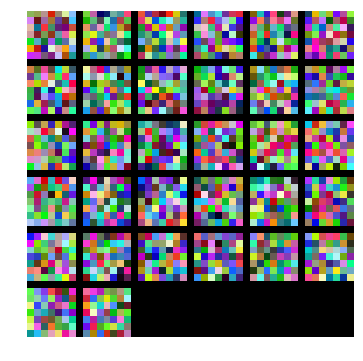

In [32]:
from dl4cv.vis_utils import visualize_grid

# first (next) parameter should be convolutional
conv_params = next(model.parameters()).data.numpy()
grid = visualize_grid(conv_params.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(6, 6)
plt.show()

# Test your Model
Run your best model on the test set. You should easily achieve a score above 10% (random guessing for a classification task with 10 classes) accuracy on the given test set:

In [35]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=50, shuffle=False, num_workers=4)

scores = []
model = overfit_model
for inputs, target in test_loader:
    inputs, targets = Variable(inputs), Variable(target)
    if model.is_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    scores.extend((preds == targets).data.cpu().numpy())
    
print('Test set accuracy: %f' % np.mean(scores))

Test set accuracy: 0.554000


## Save the Model

When you are satisfied with your training, you can save the model.

In [8]:
model.save("models/classification_cnn.model")

Saving model... models/classification_cnn.model


## Scoring function
We will score the model you have just saved based on the classification accuracy on our test dataset. The scoring function should represent the difficulty of obtaining a good test accuracy and should therefore give 0 points for worse results than random guessing, should be linear in a first regime and exponential beyond that. The onset of exponential growth depends on the problem. In that region you get twice as many points for an additional 10% accuracy.

For this problem we specifically use the following scoring function:

$$f(x) = \left\{
	\begin{array}{ll}
		0  & \mbox{if } x \leq 0.1 \\
		100x & \mbox{if } 0.1 < x \leq 0.58 \\
        \left(\frac{58}{\exp(0.58 \ln(2)/0.1)}\right) \exp(x \ln(2)/0.1) & \mbox{if } 0.58 < x \leq 1
	\end{array}
\right.$$

The function can be plotted in the following cell.

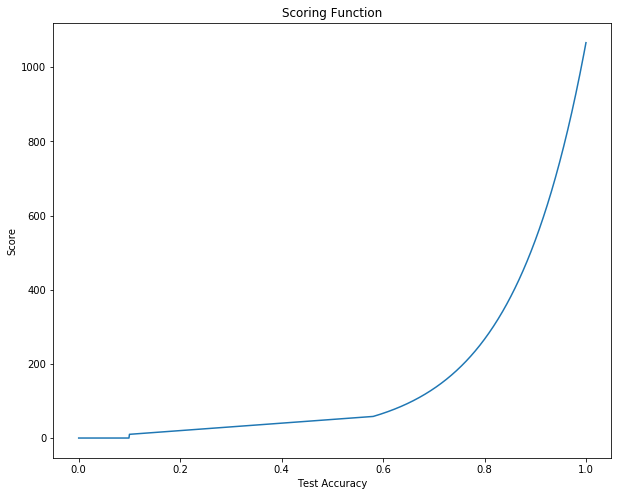

In [9]:
from dl4cv.data_utils import scoring_function

x = np.linspace(0, 1, num=1000)
plt.plot(x, scoring_function(x, lin_exp_boundary=0.58, doubling_rate=0.1))
plt.title('Scoring Function')
plt.xlabel('Test Accuracy')
plt.ylabel('Score')
plt.show()

## Possible Next Steps

1. Hyperparameter optimization
2. Data augmentation ([PyTorch tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html))
3. Improve your network architecture
    1. Increase network depth
    2. Make network convolutional
    2. Add additional layers such as [Batch normalization](https://gab41.lab41.org/batch-normalization-what-the-hey-d480039a9e3b#).
